# Taxi demand prediction in New York City

In [1]:
# We import necessary Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
from matplotlib import rcParams
import seaborn as sns
import datetime
import time
import math
import pickle
import os

import xgboost as xgb
import sklearn
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')
import tqdm
import prettytable

# please do go through this python notebook: https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
import dask.dataframe as dd # for parsing large data
import folium # for interactive maps
# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
import gpxpy.geo #Get the haversine distance


# Data Information

<p>
Ge the data from : http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml (2016 data)
The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) 
</p>

## Information on taxis:

<h5> Yellow Taxi: Yellow Medallion Taxicabs</h5>
<p> These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.</p>

<h5> For Hire Vehicles (FHVs) </h5>
<p> FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged. </p>

<h5> Green Taxi: Street Hail Livery (SHL) </h5>
<p>  The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides. </p>
<p> Credits: Quora</p>

<h5>Footnote:</h5>
In the given notebook we are considering only the yellow taxis for the time period between Jan - Mar 2015 & Jan - Mar 2016

# Data Collection

We Have collected all yellow taxi trips data from jan-2015 to dec-2016(Will be using only 2015 data)
<table>
<tr>
<th> file name </th>
<th> file name size</th>
<th> number of records </th>
<th> number of features </th>
</tr>
<tr>
<td> yellow_tripdata_2016-01 </td>
<td> 1. 59G </td>
<td> 10906858 </td>
<td> 19 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-02 </td>
<td> 1. 66G </td>
<td> 11382049 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2016-03 </td>
<td> 1. 78G </td>
<td> 12210952 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2016-04 </td>
<td> 1. 74G </td>
<td> 11934338 </td>
<td> 19 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-05 </td>
<td> 1. 73G </td>
<td> 11836853 </td>
<td> 19 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-06 </td>
<td> 1. 62G </td>
<td> 11135470 </td>
<td> 19 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-07 </td>
<td> 884Mb </td>
<td> 10294080 </td>
<td> 17 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-08 </td>
<td> 854Mb </td>
<td> 9942263 </td>
<td> 17 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-09 </td>
<td> 870Mb </td>
<td> 10116018 </td>
<td> 17 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-10 </td>
<td> 933Mb </td>
<td> 10854626 </td>
<td> 17 </td>
</tr>
<tr>
<td> yellow_tripdata_2016-11 </td>
<td> 868Mb </td>
<td> 10102128 </td>
<td> 17 </td>
</tr>
<tr>
<td> yellow_tripdata_2016-12 </td>
<td> 897Mb </td>
<td> 10449408 </td>
<td> 17 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-01 </td>
<td> 1.84Gb </td>
<td> 12748986 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-02 </td>
<td> 1.81Gb </td>
<td> 12450521 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-03 </td>
<td> 1.94Gb </td>
<td> 13351609 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-04 </td>
<td> 1.90Gb </td>
<td> 13071789 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-05 </td>
<td> 1.91Gb </td>
<td> 13158262 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-06 </td>
<td> 1.79Gb </td>
<td> 12324935 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-07 </td>
<td> 1.68Gb </td>
<td> 11562783 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-08 </td>
<td> 1.62Gb </td>
<td> 11130304 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-09 </td>
<td> 1.63Gb </td>
<td> 11225063 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-10 </td>
<td> 1.79Gb </td>
<td> 12315488 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-11 </td>
<td> 1.65Gb </td>
<td> 11312676 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-12 </td>
<td> 1.67Gb </td>
<td> 11460573 </td>
<td> 19 </td>
</tr>
</table>



In [2]:
month = dd.read_csv(r'yellow_tripdata_2015-01.csv')
month.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

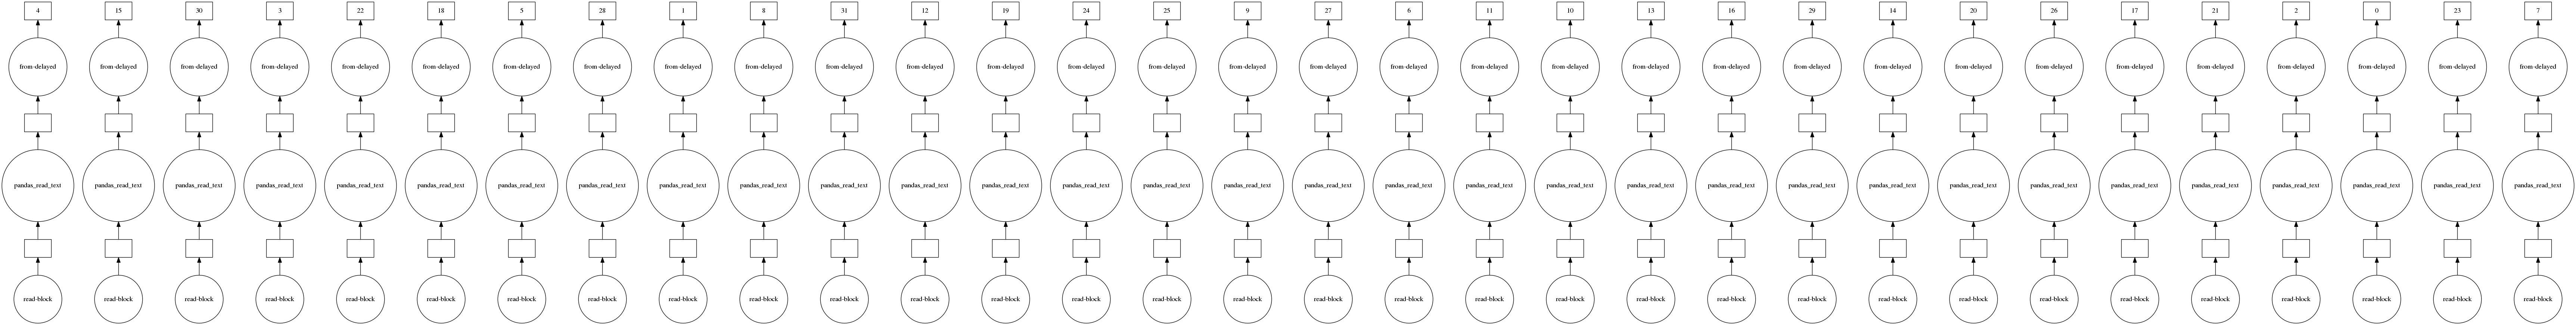

In [3]:
# However unlike Pandas, operations on dask.dataframes don't trigger immediate computation, 
# instead they add key-value pairs to an underlying Dask graph. Recall that in the diagram below, 
# circles are operations and rectangles are results.

month.visualize()

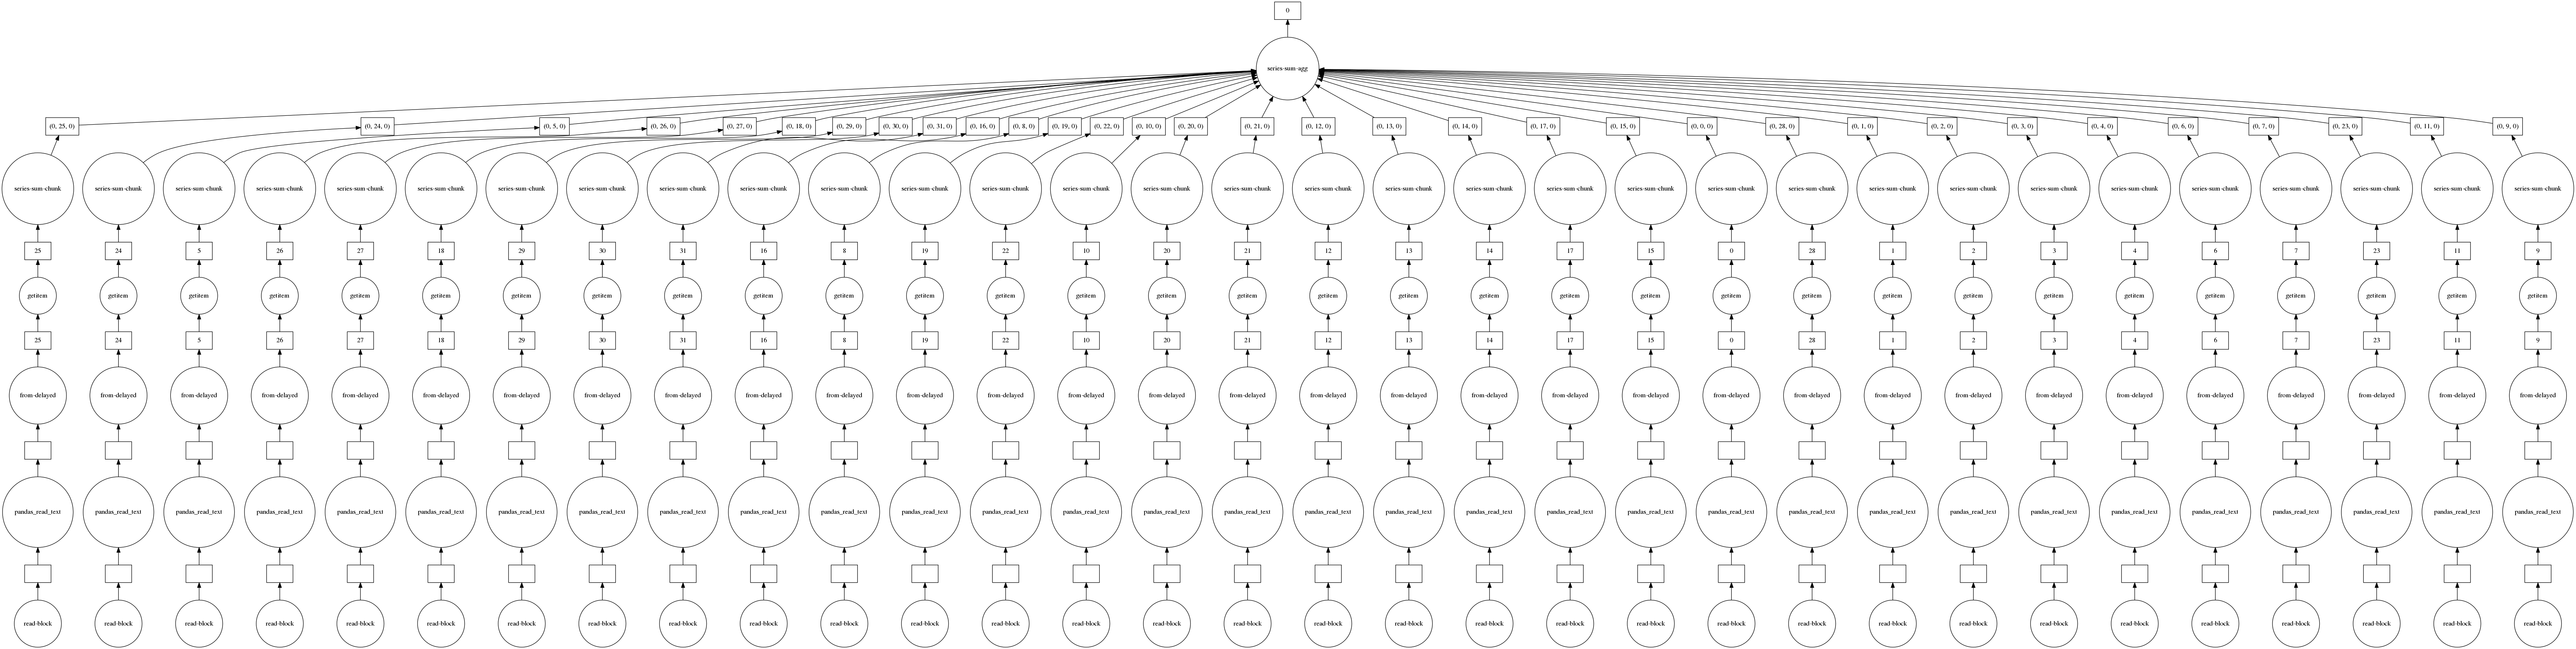

In [4]:
month.fare_amount.sum().visualize()

## Features in the dataset:
<table border="1">
	<tr>
		<th>Field Name</th>
		<th>Description</th>
	</tr>
	<tr>
		<td>VendorID</td>
		<td>
		A code indicating the TPEP provider that provided the record.
		<ol>
			<li>Creative Mobile Technologies</li>
			<li>VeriFone Inc.</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>tpep_pickup_datetime</td>
		<td>The date and time when the meter was engaged.</td>
	</tr>
	<tr>
		<td>tpep_dropoff_datetime</td>
		<td>The date and time when the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Passenger_count</td>
		<td>The number of passengers in the vehicle. This is a driver-entered value.</td>
	</tr>
	<tr>
		<td>Trip_distance</td>
		<td>The elapsed trip distance in miles reported by the taximeter.</td>
	</tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>Longitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Store_and_fwd_flag</td>
		<td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br\> aka “store and forward,” because the vehicle did not have a connection to the server.
		<br\>Y= store and forward trip
		<br\>N= not a store and forward trip
		</td>
	</tr>

	<tr>
		<td>Dropoff_longitude</td>
		<td>Longitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Dropoff_ latitude</td>
		<td>Latitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Payment_type</td>
		<td>A numeric code signifying how the passenger paid for the trip.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute</li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
	<tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.</td>
	</tr>
	<tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
	<tr>
		<td>Improvement_surcharge</td>
		<td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.</td>
	</tr>
	<tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
	<tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
	<tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
</table>

# ML Problem Formulation

<p><b> Time-series forecasting and Regression</b></p>
<br>
-<i> To find number of pickups, given location cordinates(latitude and longitude) and time, in the query reigion and surrounding regions.</i>
<p> 
To solve the above we would be using data collected in Jan - Mar 2015 to predict the pickups in Jan - Mar 2016.
</p>

# Performance metrics

1. Mean Absolute percentage error.
2. Mean Squared error.

## Data Cleaning

In this section we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error

In [5]:
month.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   
1                  N         -73.994415         40.759109             1   
2                  N         -73.951820         40.824413             2   
3                  N         -74.004326         40.719986             2   
4                  N         -74.004181         40.742653             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25           0.0   
1         14.5    0.5      0.5        2.00           0.0   
2          9.5    0.5      0.5        0.00           0.0   
3          3.5    0.5      0.5        0.00           0.0   
4         15.0    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.05  
1                    0.3         17.80  
2                    0.3         10.80  
3                    0.3          4.80  
4                    0.3         16.30

# 1. Pickup Latitude and Pickup Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.

In [6]:
# we will collect all the points outside the bounding box of newyork city to outlier_locations
# '&' is for intersection, '|' for union.
outlier_locations= month[((month['pickup_latitude'] <= 40.5774) | (month['pickup_longitude'] <= -74.15)) |
                          ((month['pickup_latitude'] >= 40.9176) | (month['pickup_longitude'] >= -73.7004))]
outlier_locations

Dask DataFrame Structure:
               VendorID tpep_pickup_datetime tpep_dropoff_datetime passenger_count trip_distance pickup_longitude pickup_latitude RateCodeID store_and_fwd_flag dropoff_longitude dropoff_latitude payment_type fare_amount    extra  mta_tax tip_amount tolls_amount improvement_surcharge total_amount
npartitions=32                                                                                                                                                                                                                                                                                          
                  int64               object                object           int64       float64          float64         float64      int64             object           float64          float64        int64     float64  float64  float64    float64      float64               float64      float64
                    ...                  ...                   ...             ...           ...              ...             ...        ...                ...               ...              ...          ...         ...      ...      ...        ...          ...                   ...          ...
...                 ...                  ...                   ...             ...           ...              ...             ...        ...                ...               ...              ...          ...         ...      ...      ...        ...          ...                   ...          ...
                    ...                  ...                   ...             ...           ...              ...             ...        ...                ...               ...              ...          ...         ...      ...      ...        ...          ...                   ...          ...
                    ...                  ...                   ...             ...           ...              ...             ...        ...                ...               ...              ...          ...         ...      ...      ...        ...          ...                   ...          ...
Dask Name: getitem, 416 tasks

In [7]:
# Plotting pickup cordinates which are outside the bounding box of New-York 
# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html
# note: you dont need to remember any of these, you dont need indeepth knowledge on these maps and plots

map_nyc = folium.Map(location=[40.6789, -73.8910], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_nyc)
map_nyc

<b>Observation:-</b> As you can see above that there are some points just outside the boundary but there are a few that are in either South america, Mexico or Canada

# 2. Dropoff Latitude & Dropoff Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with dropoffs which are within New York.

In [8]:
# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_nyc)
map_nyc

<b>Observation:-</b> The observations here are similar to those obtained while analysing pickup latitude and longitude

# 3. Trip Durations:

<p style="font-size:18px">According to NYC Taxi &amp; Limousine Commision Regulations <b style= "color:blue">the maximum allowed trip duration in a 24 hour interval is 12 hours.</b> </p>

In [9]:
""" The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while 
    binning in out data we have time in the format "YYYY-MM-DD HH:MM:SS" we convert this to python time format and then into
    unix time stamp.
"""
# https://stackoverflow.com/a/27914405

def convert_to_unix(d):
    return time.mktime(datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S").timetuple())

# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip

def return_with_trip_times(month):
    # duration= month[['tpep_pickup_datetime', 'tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup= [convert_to_unix(d) for d in month['tpep_pickup_datetime']]
    duration_dropoff= [convert_to_unix(d) for d in month['tpep_dropoff_datetime']]
    duration= (np.array(duration_dropoff) - np.array(duration_pickup)) / float(60)
    
    #calculate duration of trips
    new_df = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude',
                       'dropoff_latitude','total_amount']].compute() # compute function because we are using dask.
    new_df['trip_times']= duration
    new_df['pickup_times']= duration_pickup
    new_df['speed'] = 60 * (new_df['trip_distance'] / duration)
    
    return new_df

In [10]:
df_duration= return_with_trip_times(month)
df_duration.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      speed  
0  1.421349e+09   5.285319  
1  1.420922e+09   9.983193  
2  1.420922e+09  10.746269  
3  1.420922e+09  16.071429  
4  1.420922e+09   9.318378

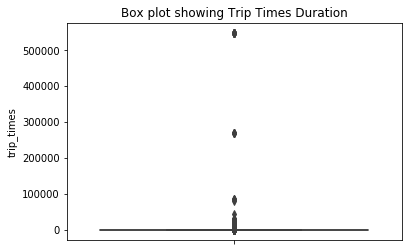

In [11]:
sns.boxplot(df_duration['trip_times'], orient= 'vertical')
plt.title('Box plot showing Trip Times Duration')
plt.show()

In [12]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0, 101, 10):
    print('The', i,'th percentile is ', np.percentile(df_duration['trip_times'], i))

The 0 th percentile is  -1211.0166666666667
The 10 th percentile is  3.8333333333333335
The 20 th percentile is  5.383333333333334
The 30 th percentile is  6.816666666666666
The 40 th percentile is  8.3
The 50 th percentile is  9.95
The 60 th percentile is  11.866666666666667
The 70 th percentile is  14.283333333333333
The 80 th percentile is  17.633333333333333
The 90 th percentile is  23.45
The 100 th percentile is  548555.6333333333


In [13]:
#looking further from the 90th percecntile
for i in range(90, 101):
    print('The', i,'th percentile is ', np.percentile(df_duration['trip_times'], i))

The 90 th percentile is  23.45
The 91 th percentile is  24.35
The 92 th percentile is  25.383333333333333
The 93 th percentile is  26.55
The 94 th percentile is  27.933333333333334
The 95 th percentile is  29.583333333333332
The 96 th percentile is  31.68333333333333
The 97 th percentile is  34.46666666666667
The 98 th percentile is  38.71666666666667
The 99 th percentile is  46.75
The 100 th percentile is  548555.6333333333


In [14]:
#removing data based on our analysis and TLC regulations
# 12hours * 60 mins  = 720mins because taxi cannot run more than that
df_duration_modified= df_duration[(df_duration['trip_times'] > 1) & (df_duration['trip_times']< 720)] 

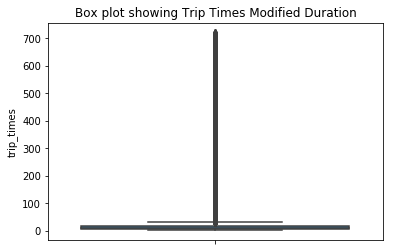

In [15]:
#box-plot after removal of outliers
sns.boxplot(df_duration_modified['trip_times'], orient= 'vertical')
plt.title('Box plot showing Trip Times Modified Duration')
plt.show()

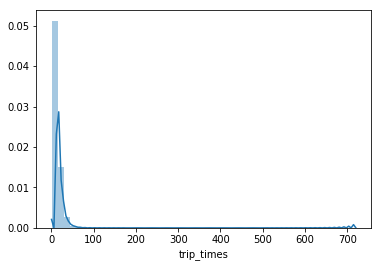

In [16]:
sns.distplot(df_duration_modified['trip_times'])
plt.show()

In [17]:
#converting the values to log-values to check for log-normal
df_duration_modified['log_times']= [math.log(i) for i in df_duration_modified['trip_times']]

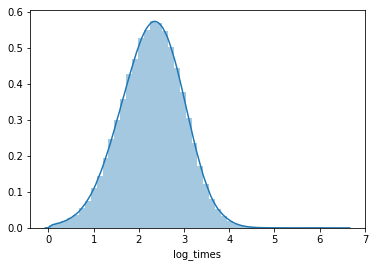

In [18]:
sns.distplot(df_duration_modified['log_times'])
plt.show()

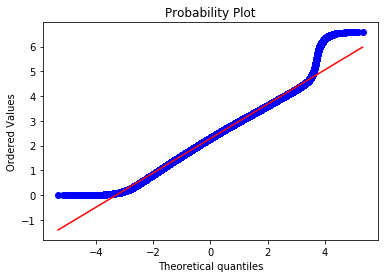

In [19]:
#Q-Q plot for checking if trip-times is log-normal
import scipy
scipy.stats.probplot(df_duration_modified['log_times'].values, plot=plt)
plt.show()

# 4. Speed

In [20]:
df_duration_modified['speed']= 60 *(df_duration_modified['trip_distance'] / df_duration_modified['trip_times'])

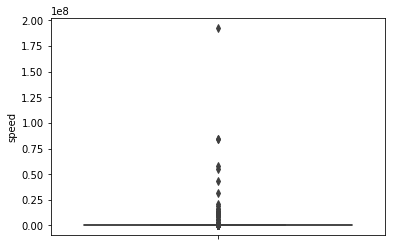

In [21]:
sns.boxplot(df_duration_modified['speed'], orient= 'vertical')
plt.show()

In [22]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0, 101, 10):
    print('The', i,'th percentile is ', np.percentile(df_duration_modified['speed'], i))

The 0 th percentile is  0.0
The 10 th percentile is  6.409495548961425
The 20 th percentile is  7.80952380952381
The 30 th percentile is  8.929133858267717
The 40 th percentile is  9.98019801980198
The 50 th percentile is  11.06865671641791
The 60 th percentile is  12.286689419795222
The 70 th percentile is  13.796407185628745
The 80 th percentile is  15.963224893917962
The 90 th percentile is  20.186915887850468
The 100 th percentile is  192857142.85714284


In [23]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90, 101):
    print('The', i,'th percentile is ', np.percentile(df_duration_modified['speed'], i))

The 90 th percentile is  20.186915887850468
The 91 th percentile is  20.916454400875093
The 92 th percentile is  21.752988047808763
The 93 th percentile is  22.721893491124263
The 94 th percentile is  23.844155844155843
The 95 th percentile is  25.182552504038775
The 96 th percentile is  26.80851063829787
The 97 th percentile is  28.84304932735426
The 98 th percentile is  31.591128254580514
The 99 th percentile is  35.75135055113604
The 100 th percentile is  192857142.85714284


In [24]:
# calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
# https://stackoverflow.com/a/7267287
l= [x / 10.0 for x in range(990, 1001)]
for i in l:
    print('The', i,'th percentile is ', np.percentile(df_duration_modified['speed'], i))

The 99.0 th percentile is  35.75135055113604
The 99.1 th percentile is  36.31081290376664
The 99.2 th percentile is  36.91470054446461
The 99.3 th percentile is  37.588235294117645
The 99.4 th percentile is  38.330334294788756
The 99.5 th percentile is  39.17580011612381
The 99.6 th percentile is  40.15384615384615
The 99.7 th percentile is  41.338029086798095
The 99.8 th percentile is  42.866243893093184
The 99.9 th percentile is  45.310675074725154
The 100.0 th percentile is  192857142.85714284


In [25]:
#removing further outliers based on the 99.9th percentile value
df_duration_modified= df_duration[(df_duration['speed'] > 0) & (df_duration['speed'] < 45.31)] 

In [26]:
#avg.speed of cabs in New-York
sum(df_duration_modified['speed']) / len(df_duration_modified['speed'])

12.450173996027528

<b style='font-size:16px'>The avg speed in Newyork speed is 12.45miles/hr, so a cab driver can travel <font color='blue'> 2 miles per 10min on avg.</font> </b>

# 5. Trip Distance

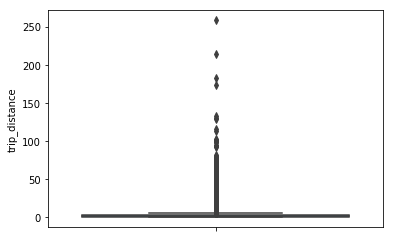

In [27]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(df_duration_modified['trip_distance'], orient= 'vertical')
plt.show()

In [28]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0, 101, 10):
    print('The', i,'th percentile is ', np.percentile(df_duration_modified['trip_distance'], i))

The 0 th percentile is  0.01
The 10 th percentile is  0.66
The 20 th percentile is  0.9
The 30 th percentile is  1.1
The 40 th percentile is  1.39
The 50 th percentile is  1.69
The 60 th percentile is  2.07
The 70 th percentile is  2.6
The 80 th percentile is  3.6
The 90 th percentile is  5.97
The 100 th percentile is  258.9


In [29]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90, 101):
    print('The', i,'th percentile is ', np.percentile(df_duration_modified['trip_distance'], i))

The 90 th percentile is  5.97
The 91 th percentile is  6.45
The 92 th percentile is  7.07
The 93 th percentile is  7.85
The 94 th percentile is  8.72
The 95 th percentile is  9.6
The 96 th percentile is  10.6
The 97 th percentile is  12.1
The 98 th percentile is  16.03
The 99 th percentile is  18.17
The 100 th percentile is  258.9


In [30]:
# calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
# https://stackoverflow.com/a/7267287
l= [x / 10.0 for x in range(990, 1001)]
for i in l:
    print('The', i,'th percentile is ', np.percentile(df_duration_modified['trip_distance'], i))

The 99.0 th percentile is  18.17
The 99.1 th percentile is  18.37
The 99.2 th percentile is  18.6
The 99.3 th percentile is  18.83
The 99.4 th percentile is  19.13
The 99.5 th percentile is  19.5
The 99.6 th percentile is  19.96
The 99.7 th percentile is  20.5
The 99.8 th percentile is  21.22
The 99.9 th percentile is  22.57
The 100.0 th percentile is  258.9


In [31]:
#removing further outliers based on the 99.9th percentile value
df_duration_modified= df_duration[(df_duration['trip_distance'] > 0) & (df_duration['trip_distance'] < 22.57)] 

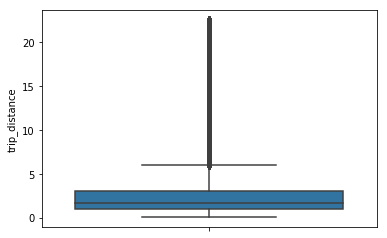

In [32]:
sns.boxplot(df_duration_modified['trip_distance'], orient= 'vertical')
plt.show()

# 5. Total Fare

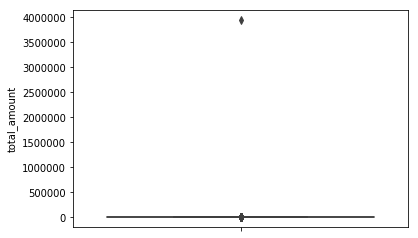

In [33]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(df_duration_modified['total_amount'], orient= 'vertical')
plt.show()

In [34]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0, 101, 10):
    print('The', i,'th percentile is ', np.percentile(df_duration_modified['total_amount'], i))

The 0 th percentile is  -242.55
The 10 th percentile is  6.3
The 20 th percentile is  7.799999999999999
The 30 th percentile is  8.8
The 40 th percentile is  9.8
The 50 th percentile is  11.16
The 60 th percentile is  12.8
The 70 th percentile is  14.8
The 80 th percentile is  18.3
The 90 th percentile is  25.8
The 100 th percentile is  3950611.6


In [35]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90, 101):
    print('The', i,'th percentile is ', np.percentile(df_duration_modified['total_amount'], i))

The 90 th percentile is  25.8
The 91 th percentile is  27.3
The 92 th percentile is  29.16
The 93 th percentile is  31.63
The 94 th percentile is  34.8
The 95 th percentile is  38.4
The 96 th percentile is  42.4
The 97 th percentile is  48.09
The 98 th percentile is  58.13
The 99 th percentile is  66.13
The 100 th percentile is  3950611.6


In [36]:
# calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
# https://stackoverflow.com/a/7267287
l= [x / 10.0 for x in range(990, 1001)]
for i in l:
    print('The', i,'th percentile is ', np.percentile(df_duration_modified['total_amount'], i))

The 99.0 th percentile is  66.13
The 99.1 th percentile is  68.13
The 99.2 th percentile is  69.6
The 99.3 th percentile is  69.6
The 99.4 th percentile is  69.73
The 99.5 th percentile is  69.75
The 99.6 th percentile is  69.76
The 99.7 th percentile is  72.46
The 99.8 th percentile is  75.33
The 99.9 th percentile is  88.05
The 100.0 th percentile is  3950611.6


<b>Observation:-</b> As even the 99.9th percentile value doesnt look like an outlier,as there is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis

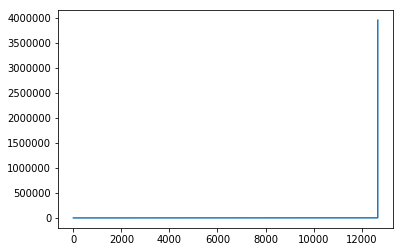

In [37]:
plt.plot(np.sort(df_duration_modified['total_amount'][df_duration_modified['total_amount'] > 88]))
plt.show()

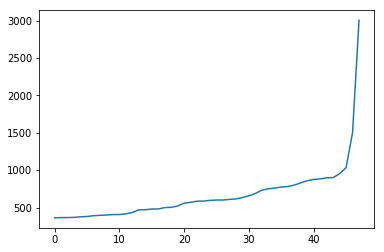

In [38]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
s = np.sort(df_duration_modified['total_amount'][df_duration_modified['total_amount'] > 88])
plt.plot(s[-50:-2])
plt.show()

# Remove all outliers/erronous points.

In [39]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.speed <= 65) & (new_frame.speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.speed < 45.31) & (new_frame.speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [40]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
df_durations_outliers_removed = remove_outliers(df_duration)
print("fraction of data points that remain after removing outliers", 
      float(len(df_durations_outliers_removed))/len(df_duration))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24473
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


# Data-preperation

## Clustering/Segmentation

In [41]:
#trying different cluster sizes to choose the right K in K-means
co_ords = df_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']]
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], 
                                                        cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,
           "\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)),
           "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),
           "\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(co_ords)
    df_durations_outliers_removed['pickup_cluster'] = kmeans.predict(co_ords)
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  1.0945442325142543 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.7131298007387813 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 22.0 
Min inter-cluster distance =  0.5185088176172206 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 32.0 
Min inter-cluster distance 

### Inference:
- The main objective was to find a optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters which we got was 40

In [42]:
# if check for the 50 clusters you can observe that there are two clusters with only 0.3 miles apart from each other
# so we choose 40 clusters for solve the further problem

# Getting 40 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(co_ords)
df_durations_outliers_removed['pickup_cluster'] = kmeans.predict(co_ords)

### Plotting the cluster centers:

In [43]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), 
                  popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

### Plotting the clusters:

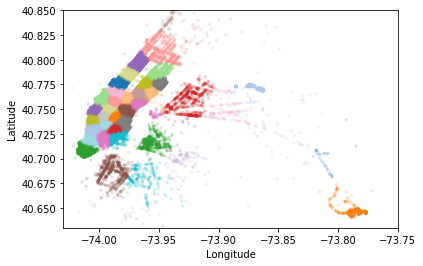

In [44]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(df_durations_outliers_removed)

# Time-binning

In [45]:
#Refer:https://www.unixtimestamp.com/
# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00

def add_pickup_bins(df,month,year):
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in GMT so we are converting it to EST.
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in df['pickup_times']]
    df['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return df

In [46]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
df_durations_outliers_removed['pickup_cluster'] = kmeans.predict(co_ords)
jan_2015_df = add_pickup_bins(df_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_df[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster',
                                                                                          'pickup_bins']).count()

# we add two more columns 'pickup_cluster'(to which cluster it belogns to) 
# and 'pickup_bins' (to which 10min interval the trip belongs to)
jan_2015_df.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      speed  pickup_cluster  pickup_bins  
0  1.421349e+09   5.285319              34         2163  
1  1.420922e+09   9.983193               2         1452  
2  1.420922e+09  10.746269              16         1452  
3  1.420922e+09  16.071429              38         1452  
4  1.420922e+09   9.318378              22         1452

In [47]:
# here the trip_distance represents the number of pickups that are happend in that particular 10min interval
# this data frame has two indices
# primary index: pickup_cluster (cluster number)
# secondary index : pickup_bins (we devided whole months time into 10min intravels 24H*60M*31D / 10M =4464bins)

jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              33                     104
               34                     200
               35                     208
               36                     141
               37                     155

In [48]:
# upto now we cleaned data and prepared data for the month 2015,

# now do the same operations for months Jan, Feb, March of 2016
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

# Data Preparation for the months of Jan,Feb and March 2016
def datapreparation(month, kmeans, month_no, year_no):
    print ("Return with trip times..") 
    df_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    df_durations_outliers_removed = remove_outliers(df_durations)
    
    print ("Estimating clusters..")
    df_durations_outliers_removed['pickup_cluster'] = kmeans.predict(df_durations_outliers_removed[['pickup_latitude', 
                                                                                                    'pickup_longitude']])
    """df_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(df_durations_
    outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])"""

    print ("Final 'groupby'ing..")
    final_updated_df = add_pickup_bins(df_durations_outliers_removed, month_no, year_no)
    final_groupby_df = final_updated_df[['pickup_cluster','pickup_bins',
                                         'trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_df, final_groupby_df
    
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

jan_2016_df, jan_2016_groupby = datapreparation(month_jan_2016, kmeans, 1, 2016)
feb_2016_df, feb_2016_groupby = datapreparation(month_feb_2016, kmeans, 2, 2016)
mar_2016_df, mar_2016_groupby = datapreparation(month_mar_2016, kmeans, 3, 2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters..
Final 'groupby'ing..
Return with trip times..
Remove outliers..
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 22437
Number of outliers from fare analysis: 5476
Total outliers removed 308177
---
Estimating clusters..
Final 'groupby'ing..
Return with trip times..
Remove outliers..
Number of pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 232444
Number of outliers

# Smoothing

In [49]:
# Gets the unique bins where pickup values are present for each each region
# for each cluster region we will collect all the indices of 10min intervals in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups

def return_unq_pickup_bins(df):
    values = []
    for i in range(0,40): # all 40 clusters in index 0 - 39.
        new = df[df['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [50]:
# for every month we get all indices of 10min intervals in which atleast one pickup got happened

#jan
jan_2015_unique = return_unq_pickup_bins(jan_2015_df)
jan_2016_unique = return_unq_pickup_bins(jan_2016_df)

#feb
feb_2016_unique = return_unq_pickup_bins(feb_2016_df)

#march
mar_2016_unique = return_unq_pickup_bins(mar_2016_df)

In [51]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(40):
    print("for the ",i,"th cluster, the number of 10min intervals with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster, the number of 10min intervals with zero pickups:  40
------------------------------------------------------------
for the  1 th cluster, the number of 10min intervals with zero pickups:  1985
------------------------------------------------------------
for the  2 th cluster, the number of 10min intervals with zero pickups:  29
------------------------------------------------------------
for the  3 th cluster, the number of 10min intervals with zero pickups:  354
------------------------------------------------------------
for the  4 th cluster, the number of 10min intervals with zero pickups:  37
------------------------------------------------------------
for the  5 th cluster, the number of 10min intervals with zero pickups:  153
------------------------------------------------------------
for the  6 th cluster, the number of 10min intervals with zero pickups:  34
------------------------------------------------------------
for the  7 th cluster, the number of 

In [52]:
jan_2015_groupby.loc[0].count() # And the remaining 40 are zero pickups and can see above (4464 - 4424 = 40) for 40 clusters

trip_distance    4424
dtype: int64

there are two ways to fill up these values
<ul>
<li> Fill the missing value with 0's</li>
<li> Fill the missing values with the avg values
<ul>
<li> Case 1:(values missing at the start)  <br>Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) </li>
<li> Case 2:(values missing in middle) <br>Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) <br> Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) </li>
<li> Case 3:(values missing at the end)  <br>Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: x \_  => ceil(x/2), ceil(x/2) </li>
</ul>
</li>
</ul>

In [53]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values, values):
    smoothed_regions=[]
    index=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[index])
                index+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [54]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values, values):
    smoothed_regions=[] # stores list of final smoothed values of each region
    ind= 0
    repeat= 0 
    smoothed_value= 0
    for r in range(0, 40):
        smoothed_bins= [] #stores the final smoothed values
        repeat= 0
        for i in range(4464):
            if repeat!= 0: # prevents iteration for a value which is already visited/resolved
                repeat-= 1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!= 0:
                    right_hand_limit= 0
                    for j in range(i, 4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit= j
                            break
                    if right_hand_limit== 0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value= count_values[ind- 1] * 1.0/((4463- i)+ 2)* 1.0                               
                        for j in range(i, 4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i- 1] = math.ceil(smoothed_value)
                        repeat=(4463- i)
                        ind-= 1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind- 1]+ count_values[ind]) * 1.0/((right_hand_limit- i)+ 2)* 1.0             
                        for j in range(i,right_hand_limit+ 1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i- 1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit- i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit= 0
                    for j in range(i, 4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit= j
                            break
                    smoothed_value= count_values[ind] * 1.0/((right_hand_limit- i)+ 1) * 1.0
                    for j in range(i, right_hand_limit+ 1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat= (right_hand_limit- i)
            ind+= 1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [55]:
# to fill Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values, jan_2015_unique)

# Jan-2015 data is smoothed, (training dataset)
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values, jan_2015_unique)

In [56]:
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*30*60/10 = 4320
# for each cluster we will have 4464 values, therefore 40*4464 = 178560 (length of the jan_2015_fill)
print("number of 10min intervals among all the clusters ",len(jan_2015_fill))
print()
print("number of 10min intervals among all the clusters ",len(jan_2015_smooth))

number of 10min intervals among all the clusters  178560

number of 10min intervals among all the clusters  178560


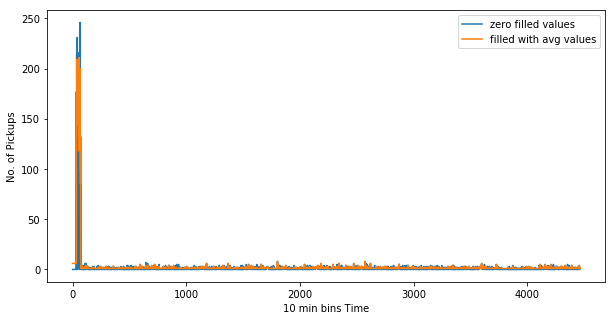

In [57]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2

plt.figure(figsize=(10,5))
plt.plot(jan_2015_fill[4464:8928], label="zero filled values")
plt.plot(jan_2015_smooth[4464:8928], label="filled with avg values")
plt.xlabel('10 min bins Time')
plt.ylabel('No. of Pickups')
plt.legend()
plt.show()

## Why we choose, these methods and which method is used for which data?

### Ans:  

Consider we have data of some month in 2015 jan 1st, 10 _ _ _ 20, i.e there are 10 pickups that are happened in 1st 
10min interval, 0 pickups happened in 2nd 10mins interval, 0 pickups happened in 3rd 10min interval, 0 pickups happened in 4th 10min interval and 20 pickups  happened in 5th 10min interval. Then in fill_missing method we replace these values like 10, 0, 0, 0, 20 where as in smoothing method we replace these values as 6, 6, 6, 6, 6. If you can check the number of pickups that are happened in the first 50min are same in both cases, but if you can observe that we are looking into the future values when you are using smoothing we are looking at the future number of pickups which might cause a data leakage, so we use smoothing for jan 2015th data since it acts as our training data and we use simple fill_missing method for 2016th data.

In [58]:

# Jan,Feb & March 2016 data missing values are filled with zero [as it is (test dataset)]
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# number of 10min indices for jan 2015= 24*31*60/10 = 4464

# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464

# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data (test dataset)

for i in range(0,40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)] + feb_2016_smooth[4176*i:4176*(i+1)] + 
                       mar_2016_smooth[4464*i:4464*(i+1)])

print(len(regions_cum))

print(len(regions_cum[0]))

40
13104


# Time series and Fourier Transforms

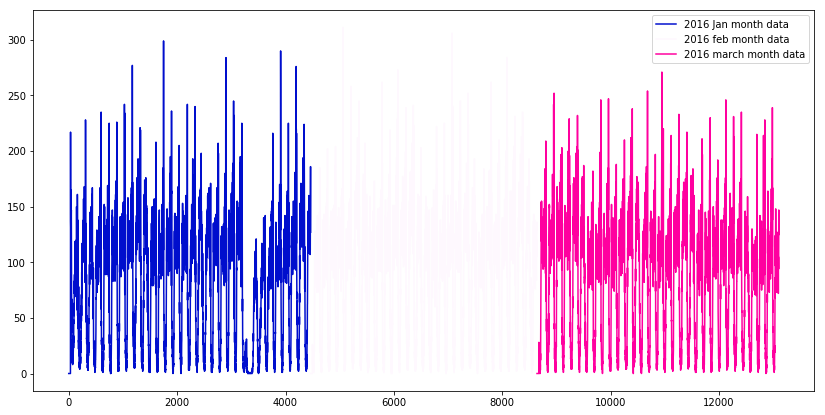

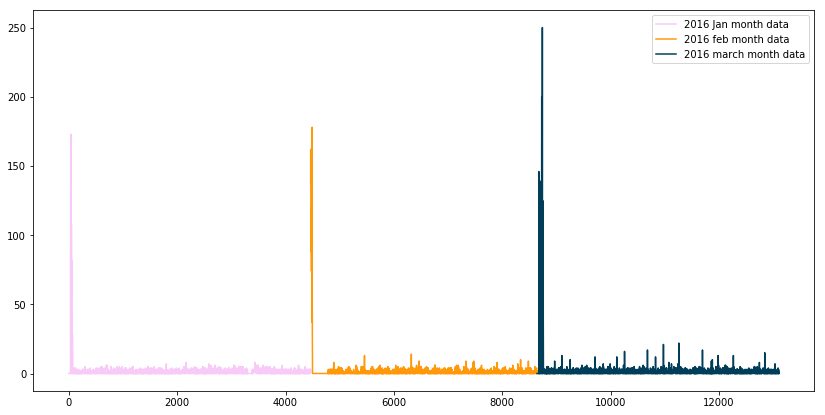

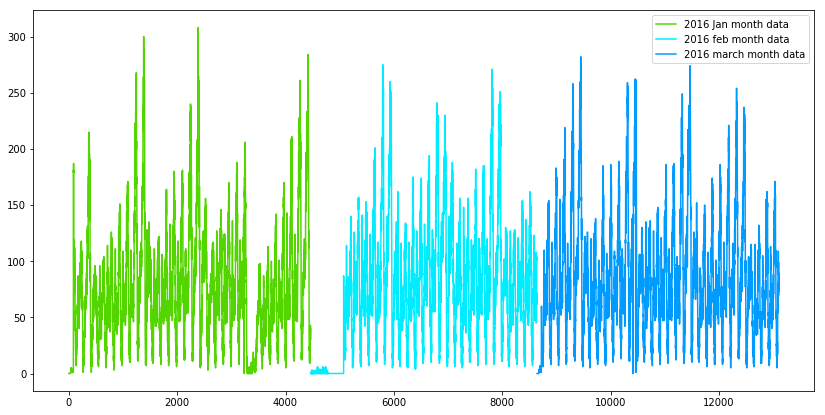

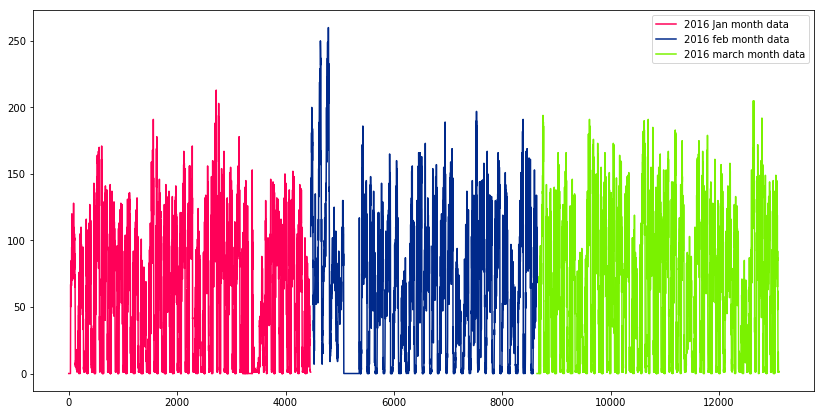

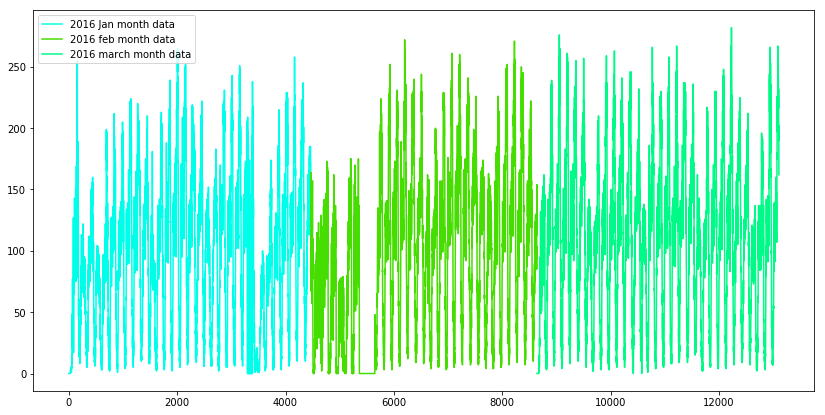

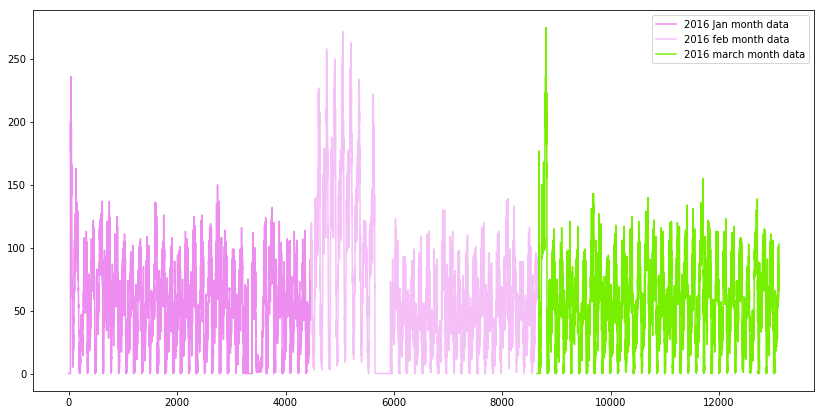

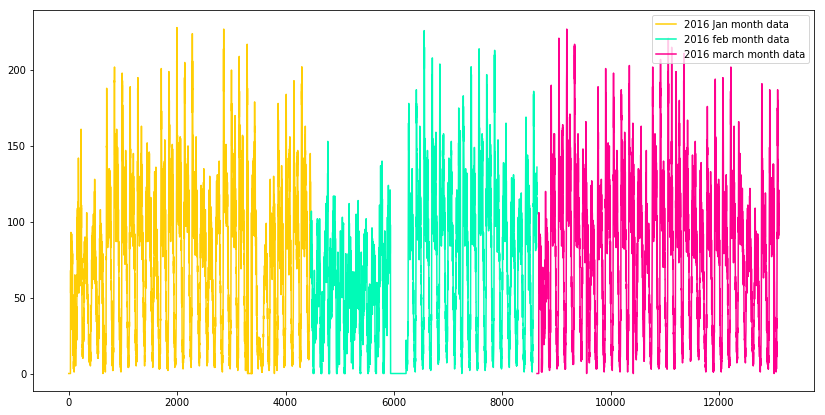

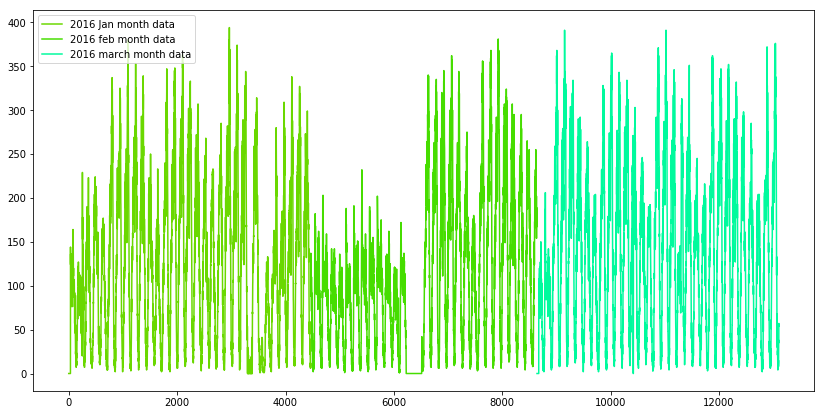

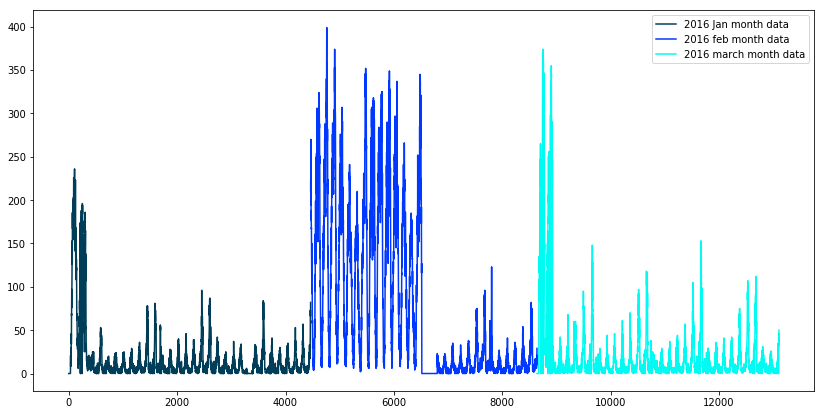

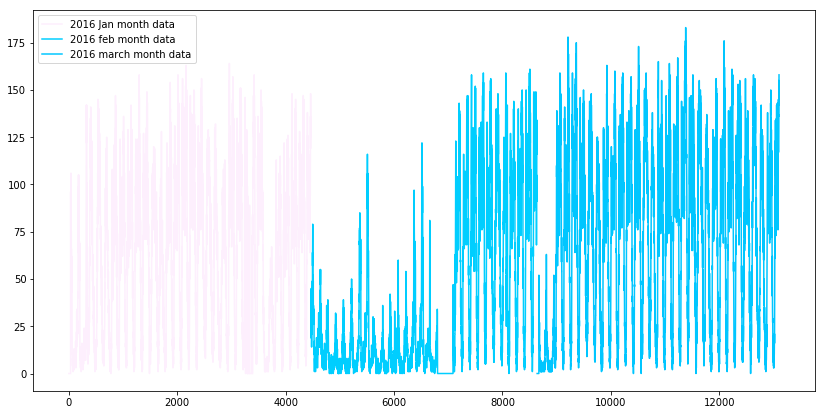

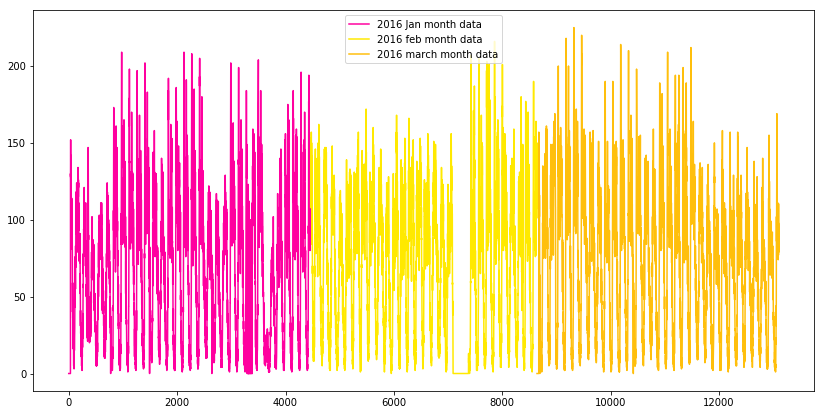

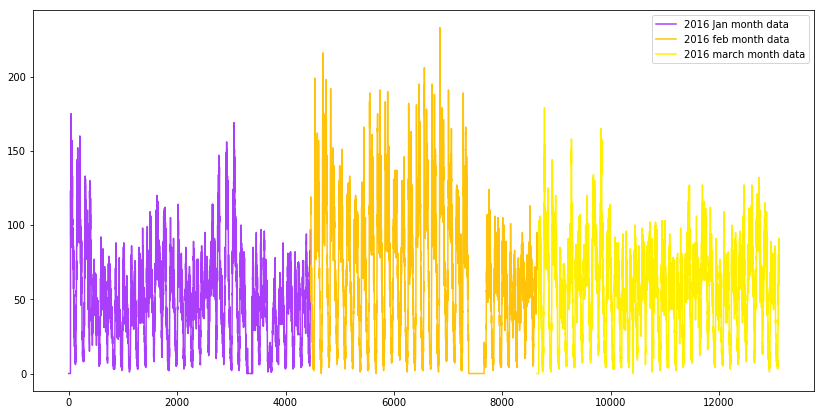

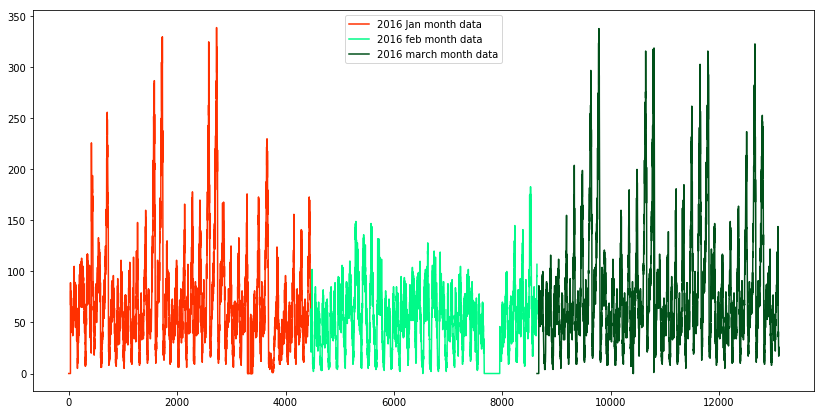

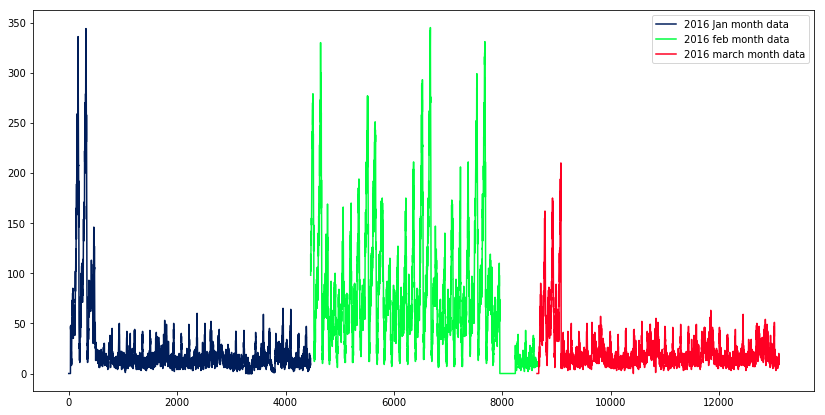

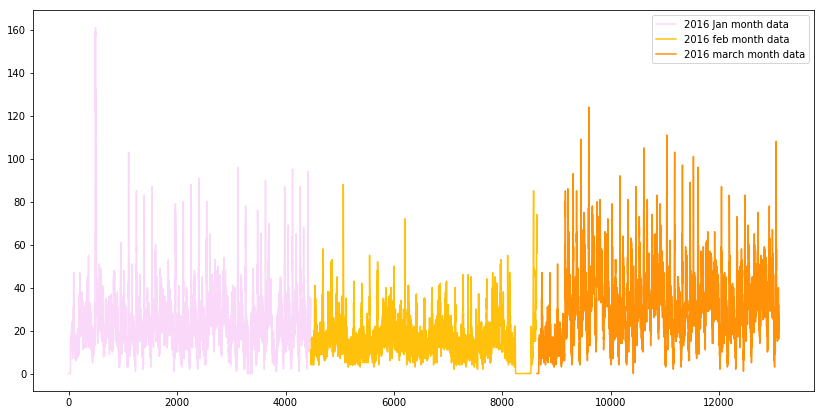

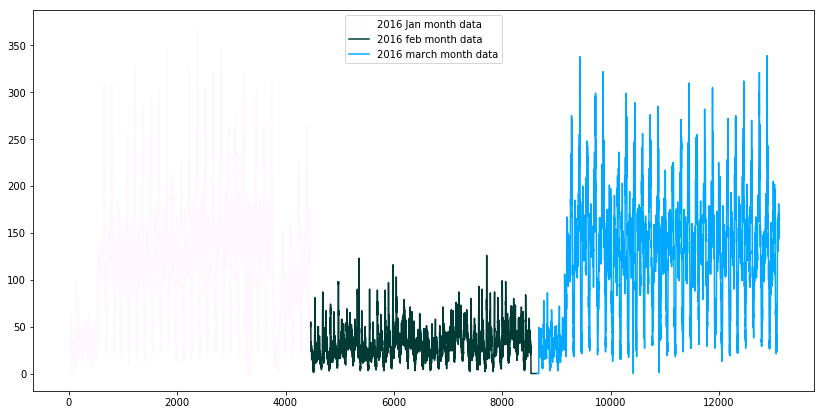

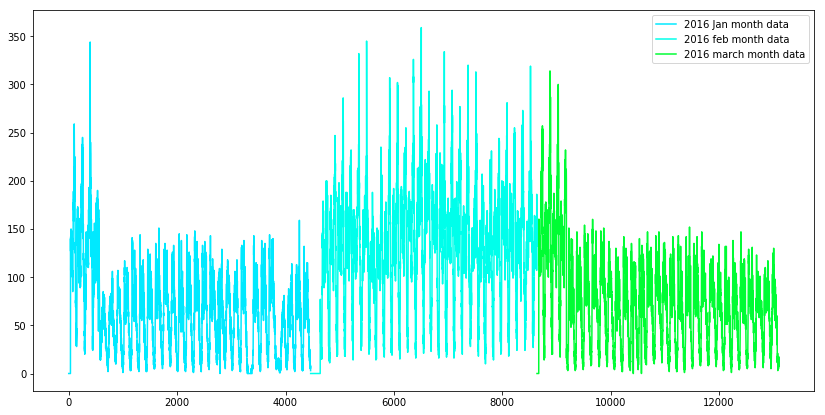

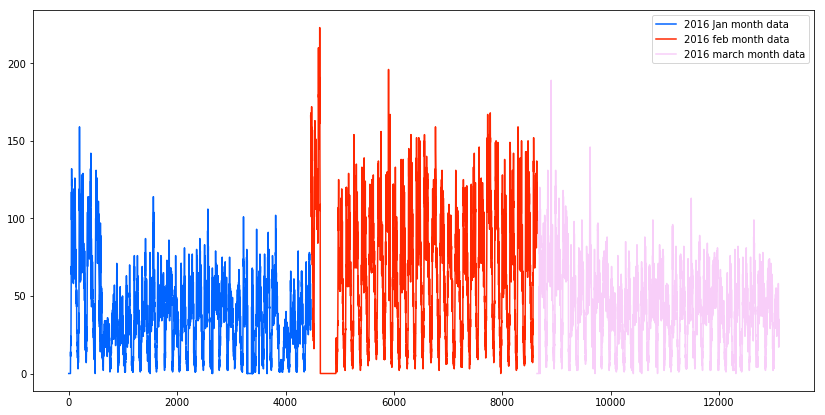

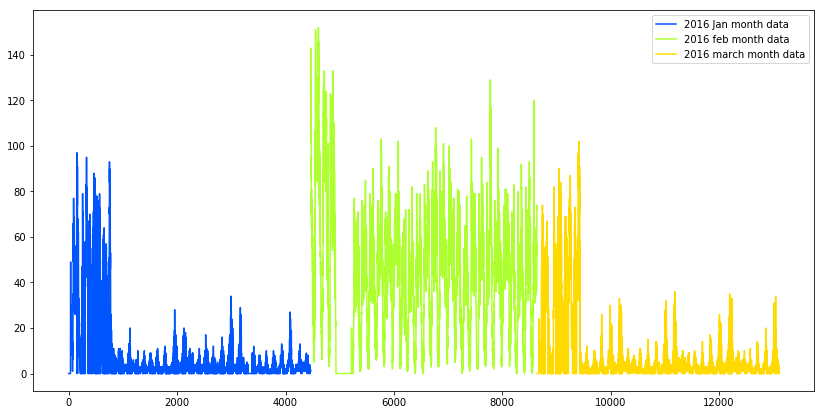

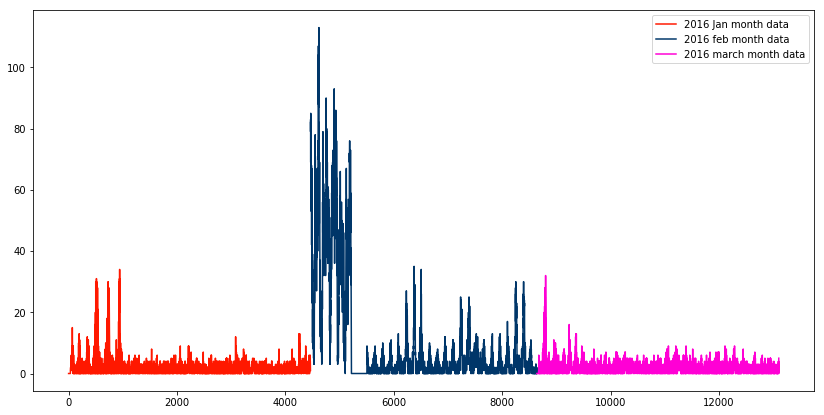

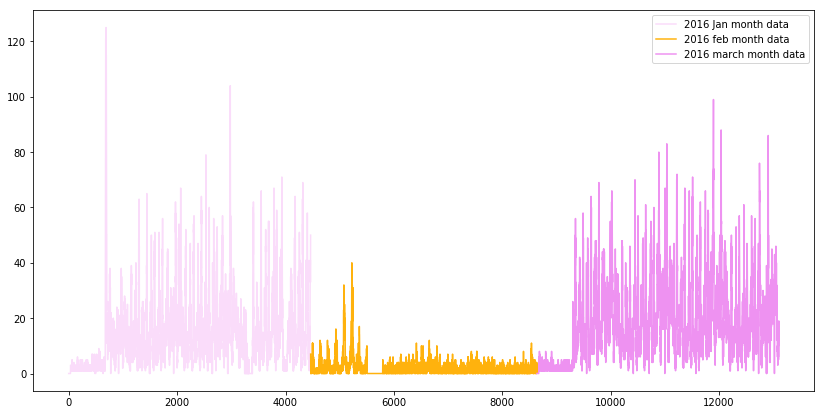

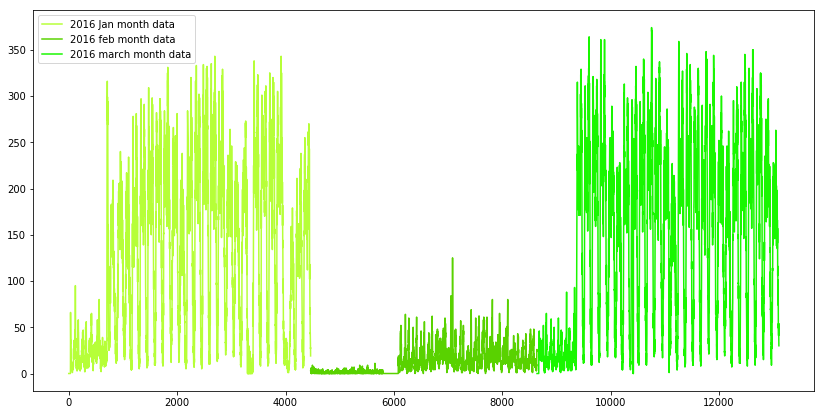

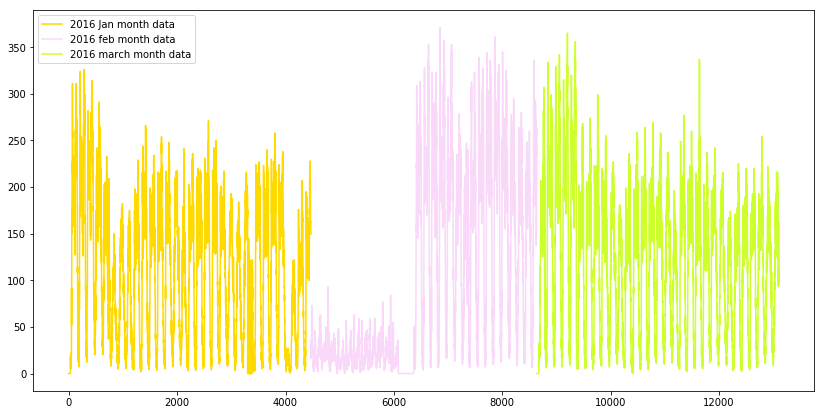

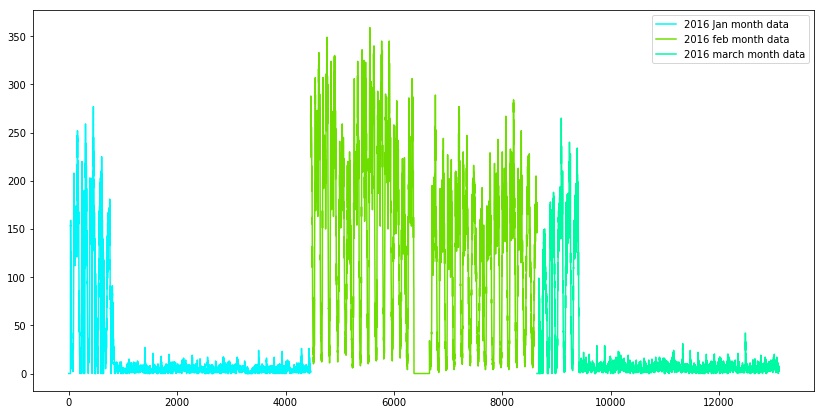

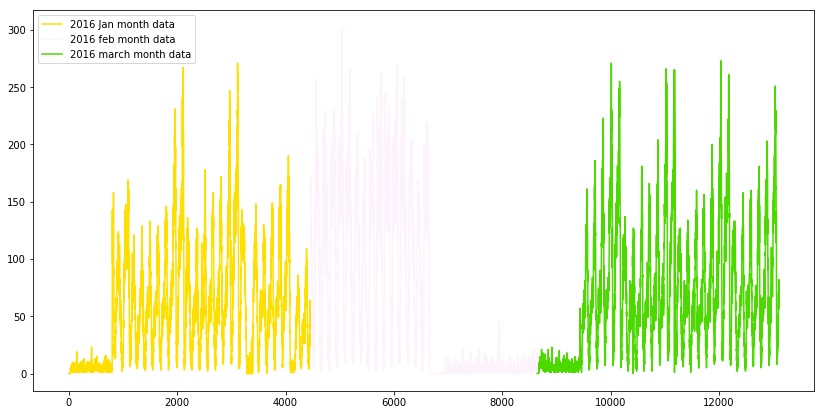

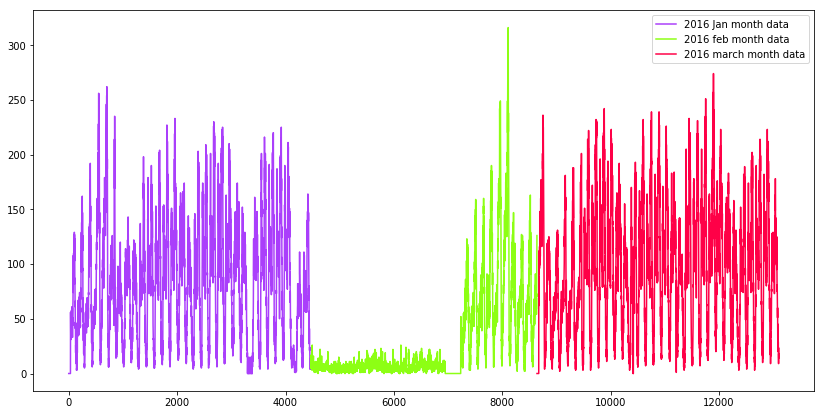

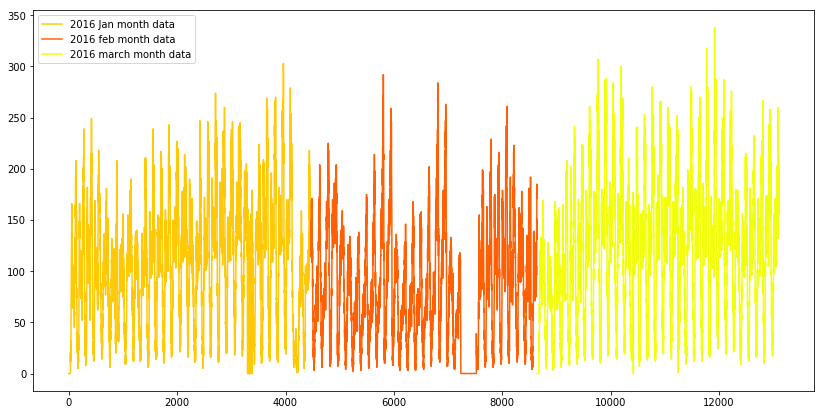

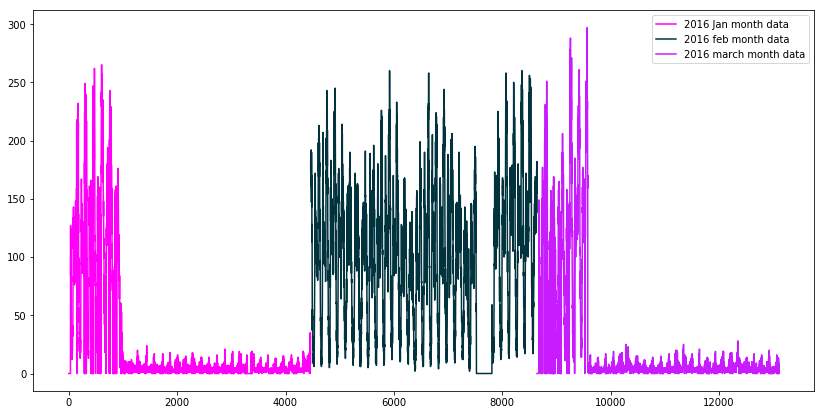

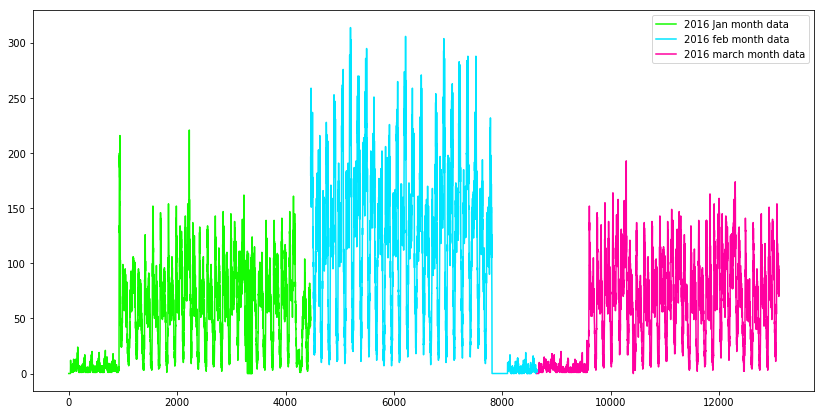

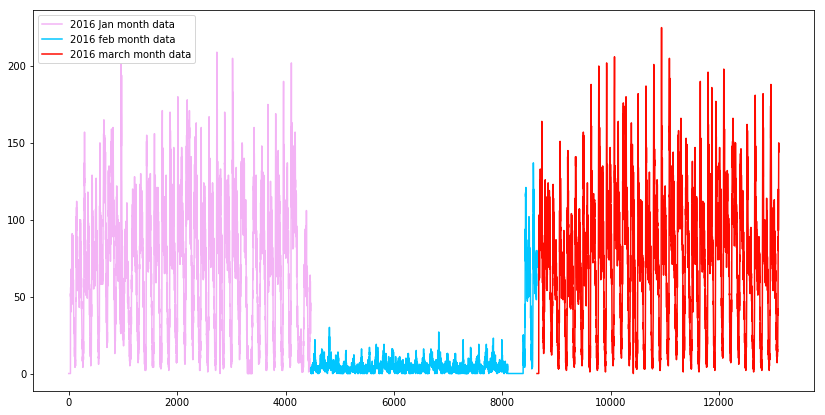

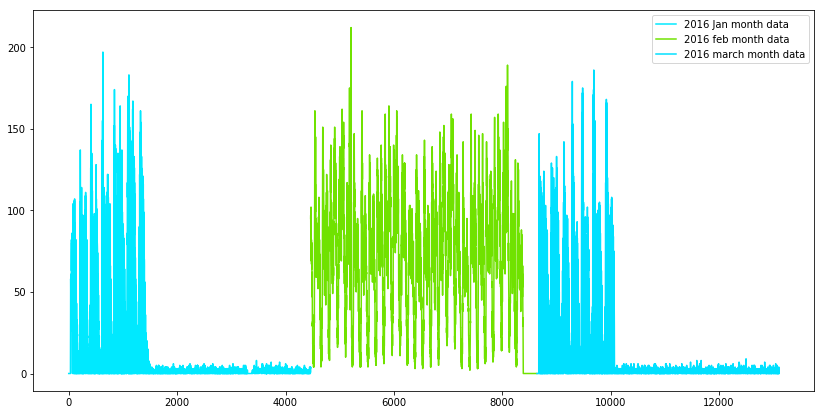

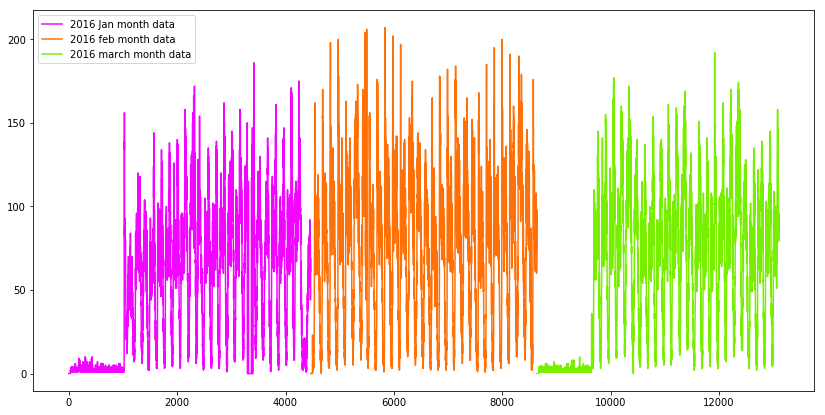

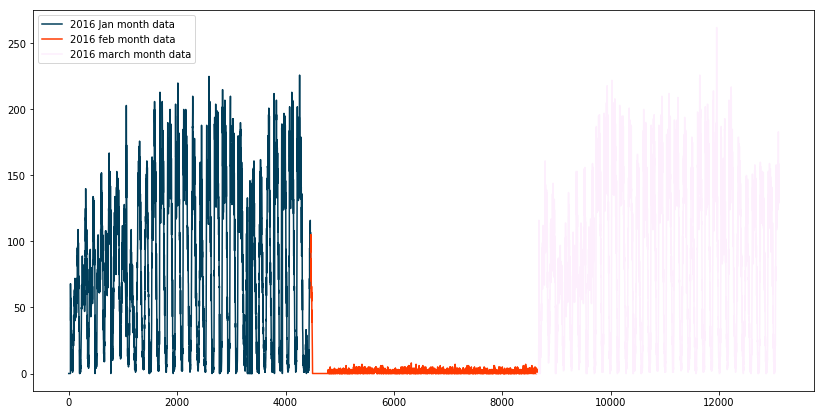

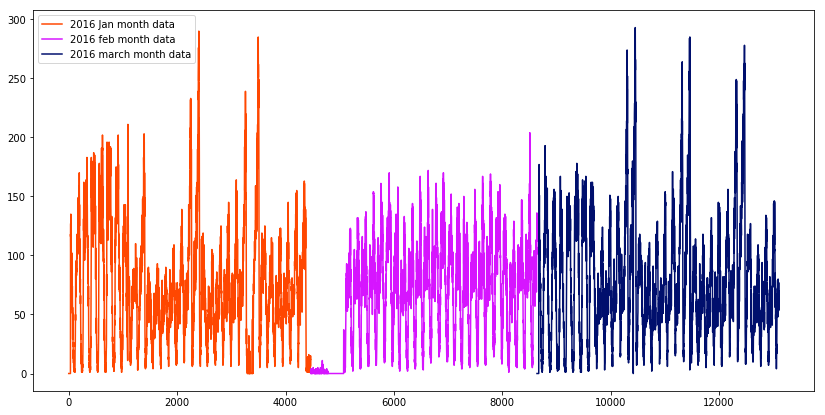

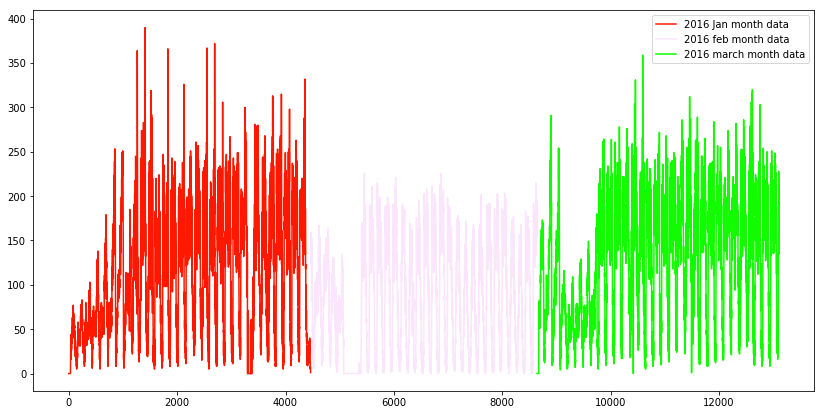

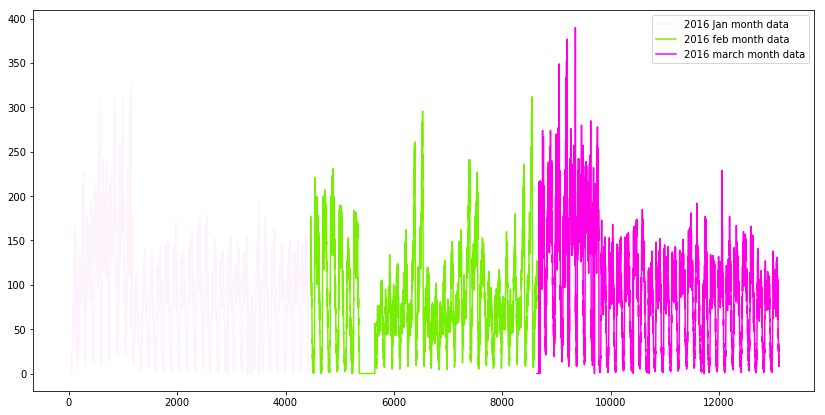

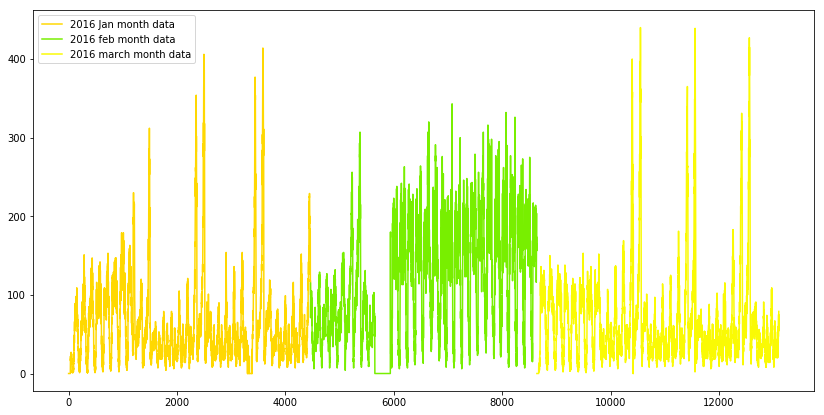

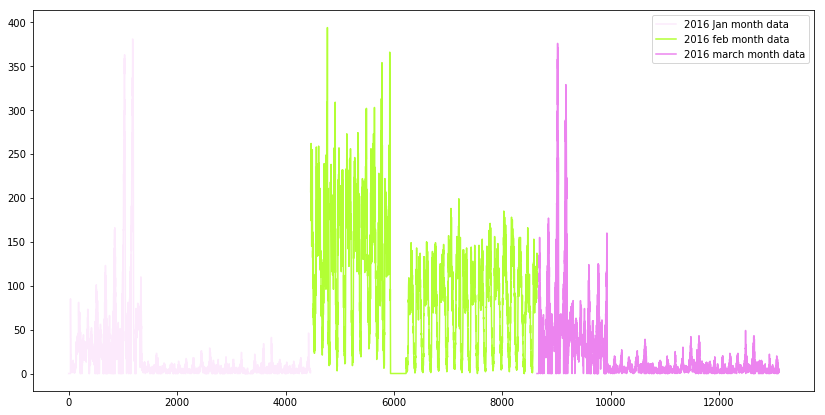

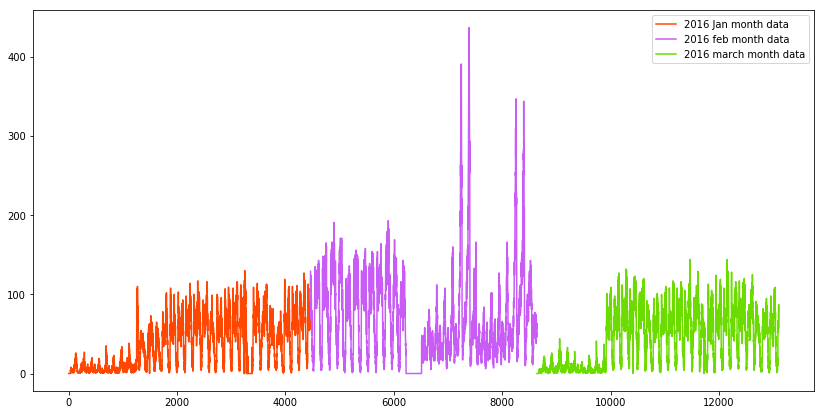

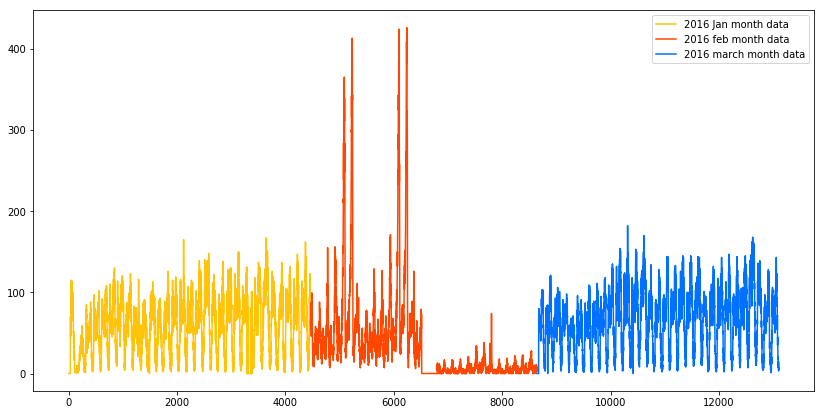

In [59]:
def uniqueish_color():
    # There're better ways to generate unique colors, but this isn't awful.
    return plt.cm.gist_ncar(np.random.random())

first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))

for i in range(40):
    plt.figure(figsize=(14,7))
    plt.plot(first_x, regions_cum[i][:4464], color= uniqueish_color(), label= '2016 Jan month data')
    plt.plot(second_x, regions_cum[i][4464:8640], color= uniqueish_color(), label= '2016 feb month data')
    plt.plot(third_x, regions_cum[i][8640:], color= uniqueish_color(), label= '2016 march month data')
    plt.legend()
    plt.show()

True


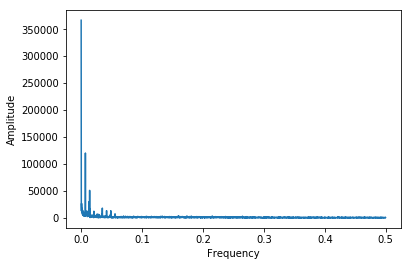

In [60]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
plt.ion()
print(matplotlib.is_interactive())
Y = np.fft.fft(np.array(jan_2016_smooth)[0:4460])

# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [61]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016

ratios_jan= pd.DataFrame()
ratios_jan['Given']= jan_2015_smooth
ratios_jan['Prediction']= jan_2016_smooth
ratios_jan['Ratios']= ratios_jan['Prediction']*1.0 / ratios_jan['Given']*1.0

## Modelling: Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2016 for which we are using multiple models with two variations 
1. Using Ratios of the 2016 data to the 2015 data i.e $\begin{align} R_{t} = P^{2016}_{t} / P^{2015}_{t} \end{align}$
2. Using Previous known values of the 2016 data itself to predict the future values

### Simple Moving Averages

The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value <br> 
Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} ) / n \end{align}$

In [62]:
def MA_R_Predictions(ratios, month):
    predicted_ratio= (ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size= 3
    predicted_ratio_values=[]
    for i in range(0, 4464*40):
        if i%4464 == 0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1 >= window_size:
            predicted_ratio= sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)]) / window_size
        else:
            predicted_ratio= sum((ratios['Ratios'].values)[0:(i+1)]) / (i+1)
            
    
    ratios['MA_R_Predicted']= predicted_values
    ratios['MA_R_Error']= error
    mape_err= (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err= sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 3 is optimal for getting the best results using Moving Averages using previous Ratio values therefore we get $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3})/3 \end{align}$

Next we use the Moving averages of the 2016  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [63]:
def MA_P_Predictions(ratios, month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 1 is optimal for getting the best results using Moving Averages using previous 2016 values therefore we get $\begin{align}P_{t} = P_{t-1} \end{align}$

### Weighted Moving Averages
The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones<br>

Weighted Moving Averages using Ratio Values - $\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$

In [64]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 5 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $\begin{align} R_{t} = ( 5*R_{t-1} + 4*R_{t-2} + 3*R_{t-3} + 2*R_{t-4} + R_{t-5} )/15 \end{align}$

Weighted Moving Averages using Previous 2016 Values - $\begin{align}P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2) \end{align}$

In [65]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages using previous 2016 values therefore we get $\begin{align} P_{t} = ( 2*P_{t-1} + P_{t-2} )/3 \end{align}$

### Exponential  Weighted Moving Averages
 https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average
Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [66]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

In [67]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
        
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err 

In [68]:
# https://grisha.org/blog/2016/02/16/triple-exponential-smoothing-forecasting-part-ii/
# Double exponential smoothing

def EA_P2_Predictions(ratios, month):
    alpha= 0.99
    beta = 0.009
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        if i == 1:
            level = ratios['Prediction'][0]
            trend = ratios['Prediction'][1] - ratios['Prediction'].values[0]
        if i >= len(ratios['Prediction']):
            value = predicted_values[-1]
        else:
            value= ratios['Prediction'][i]
        last_level, level = level, int((alpha*value + (1-alpha)*(level + trend)))
        trend = beta * (level - last_level) + (1-beta)* trend
        error.append(abs((math.pow((level + trend)-ratios['Prediction'][i],1))))
        predicted_values.append(level + trend)   
    ratios['EA_P2_Predicted'] = predicted_values
    ratios['EA_P2_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [69]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan, mean_err[0], median_err[0]= MA_R_Predictions(ratios_jan, 'jan')
ratios_jan, mean_err[1], median_err[1]= MA_P_Predictions(ratios_jan, 'jan')
ratios_jan, mean_err[2], median_err[2]= WA_R_Predictions(ratios_jan, 'jan')
ratios_jan, mean_err[3], median_err[3]= WA_P_Predictions(ratios_jan, 'jan')
ratios_jan, mean_err[4], median_err[4]= EA_R1_Predictions(ratios_jan, 'jan')
ratios_jan, mean_err[5], median_err[5]= EA_P1_Predictions(ratios_jan, 'jan')
ratios_jan, mean_err[6], median_err[6]= EA_P2_Predictions(ratios_jan, 'jan')

## Comparison between baseline models
We have chosen our error metric for comparison between models as <b>MAPE (Mean Absolute Percentage Error)</b> so that we can know that on an average how good is our model with predictions and <b>MSE (Mean Squared Error)</b> is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of a error margin between our prediction and the actual value

In [70]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])
print ("--------------------------------------------------------------------------------------------------------")
print ("Double Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[6],"      MSE: ",median_err[6])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.22785156353133512       MSE:  1196.2953853046595
Moving Averages (2016 Values) -                        MAPE:  0.15583458712025738        MSE:  254.66309363799283
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.22706529144871415       MSE:  1053.083529345878
Weighted Moving Averages (2016 Values) -               MAPE:  0.1479482182992932       MSE:  224.81054547491038
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.2275474636148534       MSE:  1019.3071012544802
Exponential Moving Averages (2016 Values) -         MAPE:  0.147538129

<b>Plese Note:-</b> The above comparisons are made using Jan 2015 and Jan 2016 only
    
From the above matrix it is inferred that the best forecasting model for our prediction would be:-
$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$ i.e Exponential Moving Averages using 2016 Values

# Regression Models

### Train-Test Split
Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

In [71]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into 
# test and train

# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464

# regions_cum (clusters): it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number 
# of pickups that are happened for three months in 2016 data

# print(len(regions_cum))
# 40 (4464 + 4176 + 4464 = 13104)
# print(len(regions_cum[0]))
# 13104

# we take number of pickups that are happened in last 5 - 10min intervals
number_of_time_stamps = 5

# output variable
# it is list of lists
# it will contain number of pickups (13104-5) = 13099 for each cluster
output = []


# tsne_lat will contain 13104-5=13099 times lattitude of cluster center for every cluster
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists]
# it is list of lists
tsne_lat = []


# tsne_lon will contain 13104-5=13099 times logitude of cluster center for every cluster
# Ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 40 lists]
# it is list of lists
tsne_lon = []

# we will code each day 
# sun= 0, mon= 1, tue= 2, wed= 3, thu= 4, fri= 5,sat= 6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numpy array, of shape (523960, 5)
# each row c orresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []

tsne_feature = [0]*number_of_time_stamps
for i in range(0,40):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 
    # pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], 
    # [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] 
                                             for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [72]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 40*13099 == len(output)*len(output[0])

True

In [73]:
# Getting the predictions of Double exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the double exponential weighted moving avarage gives us the best error
# we will try to add the same double exponential weighted moving avarage at t as a feature to our data
# https://grisha.org/blog/2016/02/16/triple-exponential-smoothing-forecasting-part-ii/
""" 
double exponential weighted moving average => 
(we need at least two points to compute the initial trend, because we have a level, trend this method can forecast not one, 
but two data points.)

                                    level    = alpha*y + (1-alpha)*(previous_level, previous_trend)
                                    trend    = beta*(level - previous_level) + (1 - beta)*(previous_trend)
                                    forecast = (level + trend)

where 'previous_level', 'previous_trend' are first and second values of series in recursive and 'y' is current value.
"""

alpha= 0.99
beta = 0.009

# it is a temporary array that store exponential weighted moving average for each 10min interval, 
# for each cluster it will get reset
# for every cluster it contains 13104 values

predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], 
# [x5,x6,x7..x13104], .. 40 lsits]

predict_list = []
tsne_flat_exp_avg = []
for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            # This is the naive method which states that the expected point is equal to the last observed point:
            predicted_values.append(0)
            continue
        if i == 1:
            level = regions_cum[r][0]
            trend = regions_cum[r][1] - regions_cum[r][0]
        if i >= len(regions_cum[r]):
            value = predicted_values[-1]
        else:
            value= regions_cum[r][i]
        last_level, level = level, int((alpha*value + (1-alpha)*(level + trend)))
        trend = beta * (level - last_level) + (1-beta)* trend
        predicted_values.append(level + trend)
    predict_list.append(predicted_values[5:])
    predicted_values=[]


In [74]:
len(predict_list)

40

In [75]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region


print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [76]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,40)]

# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

In [77]:
print("Number of data clusters: ",len(train_features), ".Number of data points in trian data: ", len(train_features[0]), 
      ".Each data point contains: ", len(train_features[0][0]),"features.")
print("Number of data clusters: ",len(train_features), ".Number of data points in test data: ", len(test_features[0]), 
      ".Each data point contains: ", len(test_features[0][0]),"features.")

Number of data clusters:  40 .Number of data points in trian data:  9169 .Each data point contains:  5 features.
Number of data clusters:  40 .Number of data points in test data:  3930 .Each data point contains:  5 features.


In [78]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_double_exp_avg = [i[:9169] for i in predict_list]

In [79]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_double_exp_avg = [i[9169:] for i in predict_list]

In [80]:
# the above contains values in the form of list of lists (i.e. list of values of each region), 
# here we make all of them in one list

train_new_features = []
for i in range(0,40):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,40):
    test_new_features.extend(test_features[i])

In [81]:
# converting lists of lists into single list i.e flatten => a= [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[])) = [1, 2, 3, 4, 4, 6, 7, 8]
# Train data

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_double_exp_avg = sum(tsne_train_flat_double_exp_avg,[])

In [82]:
# converting lists of lists into single list i.e flatten => a= [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[])) = [1, 2, 3, 4, 4, 6, 7, 8]
# Test data

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_double_exp_avg = sum(tsne_test_flat_double_exp_avg,[])

In [83]:
# Preparing the data frame for our train data

df_train = pd.DataFrame(data=train_new_features, columns= ['ft_5','ft_4','ft_3','ft_2','ft_1']) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['double_exp_avg'] = tsne_train_double_exp_avg

print(df_train.shape)

(366760, 9)


In [84]:
df_train.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  double_exp_avg
0     0     0     0     0     0  40.776228 -73.982119        4             0.0
1     0     0     0     0     0  40.776228 -73.982119        4             0.0
2     0     0     0     0     0  40.776228 -73.982119        4             0.0
3     0     0     0     0     0  40.776228 -73.982119        4             0.0
4     0     0     0     0     0  40.776228 -73.982119        4             0.0

In [85]:
# Preparing the data frame for our test data

df_test = pd.DataFrame(data=test_new_features, columns= ['ft_5','ft_4','ft_3','ft_2','ft_1']) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['double_exp_avg'] = tsne_test_double_exp_avg
print(df_test.shape)

(157200, 9)


In [86]:
df_test.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  double_exp_avg
0   143   145   119   113   124  40.776228 -73.982119        4      121.276652
1   145   119   113   124   121  40.776228 -73.982119        4      130.355162
2   119   113   124   121   131  40.776228 -73.982119        4      110.171966
3   113   124   121   131   110  40.776228 -73.982119        4      115.215418
4   124   121   131   110   116  40.776228 -73.982119        4      139.429479

# Using Linear Regression

In [87]:
sklearn.metrics.SCORERS.keys()

dict_keys(['fowlkes_mallows_score', 'adjusted_mutual_info_score', 'precision_weighted', 'recall_micro', 'neg_mean_absolute_error', 'balanced_accuracy', 'f1_weighted', 'f1_macro', 'recall', 'precision_micro', 'jaccard_micro', 'explained_variance', 'precision_samples', 'average_precision', 'jaccard_samples', 'jaccard_weighted', 'homogeneity_score', 'roc_auc', 'neg_mean_squared_log_error', 'recall_weighted', 'neg_median_absolute_error', 'brier_score_loss', 'neg_mean_squared_error', 'max_error', 'neg_log_loss', 'f1_samples', 'f1_micro', 'recall_macro', 'recall_samples', 'v_measure_score', 'f1', 'precision', 'precision_macro', 'adjusted_rand_score', 'accuracy', 'jaccard', 'r2', 'mutual_info_score', 'jaccard_macro', 'completeness_score', 'normalized_mutual_info_score'])

In [89]:
# find more about LR here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# -------------------------
# sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
# some of methods of LinearRegression()
# fit(X, y[, sample_weight]) Fit linear model.
# get_params([deep]) Get parameters for this estimator.
# predict(X) Predict using the linear model
# score(X, y[, sample_weight]) Returns the coefficient of determination R^2 of the prediction.
# set_params(**params) Set the parameters of this estimator.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1-2-copy-8/
# -----------------------
from sklearn.linear_model import LinearRegression
lr= LinearRegression().fit(df_train, tsne_train_output)


In [90]:
# Hyper param tuning.
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

rscv = RandomizedSearchCV(estimator = lr, param_distributions= parameters, cv=2, n_jobs= -1, return_train_score=True, 
                          scoring = 'neg_mean_absolute_error')
rscv.fit(df_train, tsne_train_output)

RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=None, normalize=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'copy_X': [True, False],
                                        'fit_intercept': [True, False],
                                        'normalize': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_absolute_error',
                   verbose=0)

In [91]:
print('Best parameters: \n', rscv.best_estimator_)
print()
print('neg_mean_absolute_error:', rscv.score(df_test, tsne_test_output))

Best parameters: 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

neg_mean_absolute_error: -0.4001930718375


In [92]:
lr= LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
lr.fit(df_train, tsne_train_output)

# Train
y_pred_tr = lr.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred_tr]
# Test
y_pred_ts = lr.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred_ts]

In [93]:
# Mean absolute error for train data
mae_train = mean_absolute_error(tsne_train_output, lr_train_predictions)
avg_train_output = sum(tsne_train_output) / len(tsne_train_output)
lr_train_mape = mae_train / avg_train_output
print("Train MAPE = ", lr_train_mape)

# mean absolute error for test data
mae_test = mean_absolute_error(tsne_test_output, lr_test_predictions)
avg_test_output = sum(tsne_test_output) / len(tsne_test_output)
lr_test_mape = mae_test / avg_test_output
print("Test MAPE = ", lr_test_mape)

Train MAPE =  0.00575012443252787
Test MAPE =  0.004871972205305982


# Using Random Forest Regressor

In [94]:
# Hyper param tuning.

"""
RandomForestRegressor(n_estimators=’warn’, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0,
                      warm_start=False)
"""

parameters = {'criterion':["mae", 'mse'], # 2 components
              'n_estimators': range(1, 100, 20), # 5 components
              'max_features':['auto', 'sqrt', 'log2'], # 3 components
              'min_samples_leaf': range(2, 10, 2), # 4 components
              'min_samples_split':  range(3, 10, 2)} # 4 components

# total of 480 combinations used for randomized search
rscv = RandomizedSearchCV(estimator = RandomForestRegressor(n_jobs=-1), param_distributions= parameters, cv= 2, n_jobs= -1, 
                          return_train_score=True, scoring = 'r2')
rscv.fit(df_train, tsne_train_output)

RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=-1, oob_score=False,
                                                   random_state=Non

In [96]:
print('Best parameters: \n', rscv.best_estimator_)
print()
print('neg_mean_absolute_error:', rscv.score(df_test, tsne_test_output))

Best parameters: 
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

neg_mean_absolute_error: 0.9999794911961775


In [97]:
rf = RandomForestRegressor(bootstrap= True, criterion= 'mse', max_depth= None, max_features= 'auto', max_leaf_nodes= None,
                           min_impurity_decrease= 0.0, min_impurity_split= None, min_samples_leaf= 2, min_samples_split= 5,
                        min_weight_fraction_leaf= 0.0, n_estimators= 21, n_jobs= -1, oob_score= False, random_state= None, 
                           verbose= 0, warm_start= False)
rf.fit(df_train, tsne_train_output)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [98]:
# Train
y_pred_tr = rf.predict(df_train)
rf_train_predictions = [round(value) for value in y_pred_tr]

# Test
y_pred_ts = rf.predict(df_test)
rf_test_predictions = [round(value) for value in y_pred_ts]

In [99]:
# Mean absolute error for train data
mae_train = mean_absolute_error(tsne_train_output, rf_train_predictions)
avg_train_output = sum(tsne_train_output) / len(tsne_train_output)
rf_train_mape = mae_train / avg_train_output
print("Train MAPE RFR = ", rf_train_mape)
print()

# mean absolute error for test data
mae_test = mean_absolute_error(tsne_test_output, rf_test_predictions)
avg_test_output = sum(tsne_test_output) / len(tsne_test_output)
rf_test_mape = mae_test / avg_test_output
print("Test MAPE RFR = ", rf_test_mape)

Train MAPE RFR =  0.00034058518923442605

Test MAPE RFR =  0.0016093984004585476


In [100]:
#feature importances based on analysis using random forest
print (df_train.columns)
print (rf.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'double_exp_avg'],
      dtype='object')
[2.41931383e-06 2.51772244e-06 1.82337315e-06 2.53592226e-06
 4.35833097e-05 1.88703785e-06 1.70459530e-06 1.04843244e-06
 9.99942480e-01]


# Using XgBoost Regressor

In [157]:
"""
xgboost.XGBRFRegressor(max_depth= 3, learning_rate= 1, n_estimators= 100, verbosity= 1, objective='reg:squarederror', 
                       n_jobs= 1, gpu_id= -1, gamma= 0, min_child_weight= 1, max_delta_step= 0, subsample= 0.8, 
                       colsample_bytree= 1, colsample_bylevel= 1, colsample_bynode= 0.8, reg_alpha= 0, reg_lambda= 1e-05, 
                       scale_pos_weight= 1, base_score= 0.5, random_state= 0, missing=None, **kwargs)
"""

parameters = {'learning_rate':   [0.01, 0.1],         # 2 components
              'n_estimators':    [1000, 2000],        # 2 components
              'max_depth':       [2,3,4],             # 3 components
              'min_child_weight':[3, 5],              # 2 components
              'sub_sample':      [0.6, 0.8],          # 2 components
              'colsample_bytree':[0.6, 0.8],          # 2 components
              'gamma':           [0, 0.1],            # 2 components
              'reg_alpha':       [0.005, 0.01],       # 2 components
              'reg_lambda':      [0.005, 0.01]}       # 2 components

# total of 768 combinations used for randomized search
rscv = RandomizedSearchCV(estimator = xgb.XGBRegressor(nthread=4, n_jobs=-1), param_distributions= parameters, cv= 2, 
                          n_jobs= -1, return_train_score=True, scoring = 'r2')
rscv.fit(df_train, tsne_train_output)

[12:19:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=-1, nthread=4,
                                          objective='reg:linear',
                                          random_stat...
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8],
                                        'gamma': [0, 0.1],
     

In [158]:
print('Best parameters: \n', rscv.best_estimator_)

Best parameters: 
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=5, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=0.01, reg_lambda=0.01, scale_pos_weight=1, seed=None,
             silent=None, sub_sample=0.8, subsample=1, verbosity=1)


In [160]:
xgbr = xgb.XGBRegressor(base_score= 0.5, booster= 'gbtree', colsample_bylevel= 1, colsample_bynode= 1, colsample_bytree= 0.8,
                    gamma= 0.1, importance_type= 'gain', learning_rate= 0.1, max_delta_step= 0, max_depth=4, 
                    min_child_weight= 5, missing= None, n_estimators= 2000, n_jobs= -1, nthread= 4, objective= 'reg:linear',
                    random_state= 0, reg_alpha= 0.01, reg_lambda= 0.01, scale_pos_weight= 1, seed= None, silent= None, 
                    sub_sample= 0.8, subsample= 1, verbosity= 1)
xgbr.fit(df_train, tsne_train_output)

[12:34:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=5, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=0.01, reg_lambda=0.01, scale_pos_weight=1, seed=None,
             silent=None, sub_sample=0.8, subsample=1, verbosity=1)

In [161]:
# Train
y_pred_tr = xgbr.predict(df_train)
xgbr_train_predictions = [round(value) for value in y_pred_tr]

# Test
y_pred_ts = xgbr.predict(df_test)
xgbr_test_predictions = [round(value) for value in y_pred_ts]

In [162]:
# Mean absolute error for train data
mae_train = mean_absolute_error(tsne_train_output, xgbr_train_predictions)
avg_train_output = sum(tsne_train_output) / len(tsne_train_output)
xgbr_train_mape = mae_train / avg_train_output
print("Train MAPE RFR = ", xgbr_train_mape)
print()

# mean absolute error for test data
mae_test = mean_absolute_error(tsne_test_output, xgbr_test_predictions)
avg_test_output = sum(tsne_test_output) / len(tsne_test_output)
xgbr_test_mape = mae_test / avg_test_output
print("Test MAPE RFR = ", xgbr_test_mape)

Train MAPE RFR =  0.0019112728770059215

Test MAPE RFR =  0.0019226746173049453


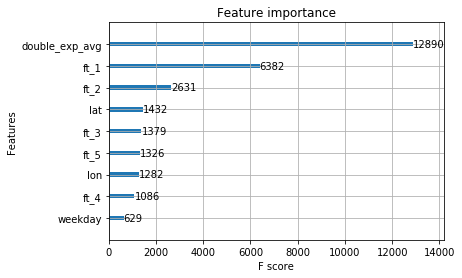

In [163]:
#feature importances
xgb.plot_importance(xgbr, importance_type = 'weight')

# Calculating the error metric values for various models

In [165]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output, df_train['ft_1'].values)) / (sum(tsne_train_output) / len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, df_train['double_exp_avg'].values)) / (sum(tsne_train_output) / len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values)) / (sum(tsne_test_output) / len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['double_exp_avg'].values)) / (sum(tsne_test_output) / len(tsne_test_output)))

# Error Metric Matrix

In [168]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Rank", "Model", "Train MAPE", "Test MAPE"]
x.add_row([1, "Random Forest Regression", rf_train_mape, rf_test_mape])
x.add_row([2, "XgBoost Regressor", xgbr_train_mape, xgbr_test_mape])
x.add_row([3, "Linear Regression",lr_train_mape, lr_test_mape])
x.add_row([4, "Double Exponential Averages Forecasting", train_mape[1], test_mape[1]])
x.add_row([5, "Baseline Model", train_mape[0], test_mape[0]])

print(x)

+------+-----------------------------------------+------------------------+-----------------------+
| Rank |                  Model                  |       Train MAPE       |       Test MAPE       |
+------+-----------------------------------------+------------------------+-----------------------+
|  1   |         Random Forest Regression        | 0.00034058518923442605 | 0.0016093984004585476 |
|  2   |            XgBoost Regressor            | 0.0019112728770059215  | 0.0019226746173049453 |
|  3   |            Linear Regression            |  0.00575012443252787   |  0.004871972205305982 |
|  4   | Double Exponential Averages Forecasting |  0.010340396198371448  |  0.009790644161288099 |
|  5   |              Baseline Model             |  0.14870666996426116   |  0.14225522601041551  |
+------+-----------------------------------------+------------------------+-----------------------+
